<b>The Geography of Climate Migration</b>

*Michał Burzyński* (michal.burzynski@liser.lu), *Frédéric Docquier* (frederic.docquier@liser.lu) & *Hendrik Scheewel* (hendrik.scheewel@uliege.be)

# Load packages

In [1]:
# import packages
import datetime
import io
import itertools
import math
from itertools import cycle
from string import ascii_lowercase as abc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import requests
import seaborn as sns
import statsmodels.formula.api as sm
from IPython.display import HTML
from matplotlib import rcParams
from numba import float64, guvectorize, jit, njit, vectorize
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

sns.set_palette('Paired')
colors = sns.color_palette()
sns.set()
sns.set(style="white")
#rcParams['font.family'] = 'monospace'
rcParams['font.family'] = 'serif'

# Latex rendering of fonts
from matplotlib import rc
rc('text', usetex=True)

In [2]:
from ipywidgets import HTMLMath

In [3]:
R = ('a', 'n')                      # regions
S = ('l', 'h')                      # skills
B = ('d', 'f')                      # areas
T = (2010, 2040, 2070, 2100)  # periods of interest

# Model class

In [4]:
class model:
    def __init__(self,
                 name, # name of the model instance
                 label=None, # label for plots
                 σ={'a': math.inf, 'n': 2.0}, # elasticity of substitution
                 μ=1.4, # 1/elasticity of mig. to wages
                 χ={'d': 0.0, 'f': 0.5}, # income loss due to forced discplacement
                 τ={'a': 0.0, 'n': 0.0}, # utility loss due to CLC
                 κ = {'a': 0.0, 'n': 0.198009171657804},
                 Γ__η_bar = {'a': 1.32558139534884, 'n': 1.878},
                 ε = {'a': 0.324228560775267, 'n': 0.276894909527694},
                 γ = 1.00256317290118,
                 tol=1e-5, # tolerance parameter
                 inputs='inputs.xlsx', # input of data
                 sea_level = 1.1,
                 temperature = 2.09): # climate change scenario
        
        self.κ = κ
        self.Γ__η_bar = Γ__η_bar
        self.ε = ε
        self.γ = γ
        
        self.σ, self.τ, self.μ, self.χ, self.tol  = σ, τ, μ, χ, tol
        self.sea_level = sea_level
        self.temperature = temperature
        
        
        self.name = name
        self.label = label
        
        def get_input(which, dim): 
            ''' Function that unpacks inputs of the model '''
            return pd.read_excel(inputs,
            sheet_name=dim,
            index_col=0,
            header=list(range(len(dim)))).sort_index()

        # Load country-specific data
        # i = country-specific
        data_i = get_input(inputs, 'i')
        data_i.index.name = 'Country'
        # irt  = country-region-time-specific
        data_irt = get_input(inputs, 'irt')
        data_irt.columns.names = ['Variable','r','t']
        data_irt.index.name = 'Country'
        # irst = country-region-skill-time-specific
        data_irst = get_input(inputs, 'irst')
        data_irst.columns.names = ['Variable','r','s','t']
        data_irst.index.name = 'Country'
        # irsbt = country-region-skill-area-time-specific
        data_irsbt = get_input(inputs, 'irsbt')  
        data_irsbt.columns.names = ['Variable','r','s','b','t']
        data_irsbt.index.name = 'Country'
        # irsbt = origin-destination-region-skill-time-specific
        data_ijrst = get_input(inputs, 'ijrsbt') 
        data_ijrst.columns.names = ['Variable','r','s','b','t','Destination']
        data_ijrst.index.name = 'Country'
        
        # Assign country-specific data
        self.countries = data_i.index
        self.OECD = data_i['OECD'] # OECD indicator
        self.iso = data_i['iso3'] # iso3 Code
        self.wbregion = data_i['wbregion'] # World Bank region
        self.income_group = data_i['income_group'] # Income group
        self.georegion = data_i['georegion'] # Geographical region
        self.bddm = data_i['bddm'] # BDDM regions
        self.latitude = data_i['latitude'] # Latitude
        self.longitude = data_i['longitude'] # Latitude
        self.Y = data_irt['Y'] # GDP
        self.Γ__w = data_irt['Γ__w'] # high-to-low-skill wage ratio
        self.L = data_irst['L'] # resident population
        self.mii = data_irsbt['mii'] # emigrant to stayer ratio (internal)
        self.Mij = data_ijrst['Mij'] # number of emigrants
        self.n = data_irsbt['n']
        self.p = data_irsbt['p']
        
        
        # Temperature scenario
        self.D = pd.read_excel(inputs,
            sheet_name='temperature',
            index_col=0,
            header=[0,1,2,3])[temperature]['D']
        self.D.columns.names = ['r','t']
        
        # Sea-level rise scenario
        self.ω = pd.read_excel(inputs,
            sheet_name='sea_level',
            index_col=0,
            header=[0,1,2,3])[sea_level]['ω']
        self.ω.columns.names = ['r','t']
        
        # Geodataframe containing shape information
        self.shapes = gpd.read_file('shapes/shapes.shp').set_index('Country')
        
        # Lexsort all dataframes:
        for i in list(self.__dict__):
            if isinstance(self.__dict__[i],pd.DataFrame):
                try:
                    if self.__dict__[i].columns.is_lexsorted() == False:
                        self.__dict__[i].columns.sortlevel(inplace=True)
                except:
                    pass

                
        self.Y_data = self.Y
        self.Γ__w_data = self.Γ__w
        self.L_data = self.L
        self.Mij_data = self.Mij

In [5]:
def MidxDataFrame(self,dim,value=np.nan):
    """ Creates multi-indexed empty dataframe with country-index"""
    
    MultiIndexDic = {
    'irt': {
        'levels': [R,T],
        'names': ['r','t'],
    },
    'ist': {
        'levels': [S,T],
        'names': ['s','t'],
    },
    'irs': {
        'levels': [R,S],
        'names': ['r','s'],
    },
    'irst': {
        'levels': [R,S,T],
        'names': ['r','s','t'],
    },
    'irsbt': {
        'levels': [R,S,B,T],
        'names': ['r','s','b','t'],
    },
    'ijrs': {
        'levels': [R,S,list(self.countries)],
        'names': ['r','s','Destination'],
    },
    'ijrst': {
        'levels': [R,S,T,list(self.countries)],
        'names': ['r','s','t','Destination']
    },
    'ijrsbt': {
        'levels': [R,S,B,T,list(self.countries)],
        'names': ['r','s','b','t','Destination']
    },
    'ijrsft': {
        'levels': [R,S,['f'],T,list(self.countries)],
        'names': ['r','s','b','t','Destination']}}
    
    
    return(pd.DataFrame(value, index=self.countries,
                        columns=pd.MultiIndex.from_product(
                            MultiIndexDic[dim]['levels'],
                            names=MultiIndexDic[dim]['names']).sortlevel()[0]))

model.MidxDataFrame = MidxDataFrame

## Functions

### Calibration functions

In [6]:
#############################
''' Calibration functions '''
#############################

# The following two functions are the inverse functions of mii and mij
def xii_fun(self,r, s):
    ''' internal migration cost'''
    return(1 - self.mii[(r,s,'d',2010)]**self.μ * (self.v[(r,s,'d',2010)]/self.v[('n',s,'d',2010)]))

model.xii_fun = xii_fun

def xij_fun(self,r, s):
    ''' international migration cost '''
    return(np.array(1 - self.mij[(r,s,'d',2010)]**self.μ * (1/self.V[(r,s,'d',2010)])\
                    * (1 - np.diag(np.ones(len(self.countries))))))

model.xij_fun = xij_fun

### Model functions

In [7]:
#######################
''' Model functions '''
#######################

def Γ__L_fun(self,r, t):
    ''' Skill ratio in the labor force '''
    return(self.L[(r, 'h', t)] / self.L[(r, 'l', t)])

model.Γ__L_fun = Γ__L_fun

def Γ__η_fun(self, r, t):
    ''' Skill bias in relative productivity '''
    return(self.Γ__η_bar[r] * self.Γ__L[(r, t)]**self.κ[r])

model.Γ__η_fun = Γ__η_fun

def η_fun(self, r, s, t):
    ''' Relative productivity '''
    if s == 'h':
        return(self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)]))
    else:
        return(1 / (1 + self.Γ__η[(r, t)]))
    
model.η_fun = η_fun


def A_fun(self, r, t):
    ''' Total factor productivity '''
    return (self.γ**(t - 2010) * self.D[(r, t)] * self.A_bar[r] * self.Γ__L[(r, t)]**self.ε[r])

model.A_fun = A_fun

def Y_fun(self, r, t):
    ''' Gross domestic product '''
    if r == 'n':
        return(self.A[(r, t)]\
               * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]**((self.σ[r]-1)/self.σ[r])\
                  + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]**((self.σ[r]-1)/self.σ[r]))**(self.σ[r]/(self.σ[r]-1)))
    else:
        return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)] + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]))

model.Y_fun = Y_fun

def w_fun(self, r, s, t):
    ''' Wage rate '''
    if r == 'a':
        return (self.η[(r, s, t)] * self.A[(r, t)])
    if r == 'n':
        return (self.η[(r, s, t)] * self.A[(r, t)] ** ((self.σ[r]-1)/self.σ[r]) 
                * (self.Y[(r, t)] / self.L[(r, s, t)])**(1 / self.σ[r]))
    
model.w_fun = w_fun
    
def Γ__w_fun(self, r, t):
    ''' High-low-skilled wage ratio '''
    return(self.w[(r, 'h', t)]/self.w[(r, 'l', t)])

model.Γ__w_fun = Γ__w_fun

def c_fun(self, r, s, b, t):
    ''' Consumption '''
    return(self.w[(r, s, t)] )

model.c_fun = c_fun


def v_fun(self, r, s, b, t):
    ''' Inner utility '''
    return((1 - self.τ[r]) * self.c[(r, s, b, t)])

model.v_fun = v_fun

def V_fun(self, r, s, b, t):
    ''' Relative utility between two regions '''
    return(np.outer(1/self.v[(r,s,b,t)],self.v[('n',s,'d',t)]))

model.V_fun = V_fun

def mii_fun(self, r, s, b, t):
    ''' Internal emigrant to stayer ratio '''
    return(((self.v[('n', s, 'd', t)]/self.v[(r, s, b, t)])
            * ( (1-self.xii[(r, s)])/(1-self.χ[b])))**(1/self.μ))

model.mii_fun = mii_fun

def mij_fun(self, r, s, b, t):
    ''' International emigrant to stayer ratio'''
    return(np.array(self.V[(r,s,'d',t)]**(1/self.μ)\
                    * ((1-self.xij[(r,s)])/(1-self.χ[b]))**(1/self.μ)\
                    * (1-np.diag(np.ones(len(self.countries))))))    

model.mij_fun = mij_fun

def Ms_fun(self, r, s, b, t):
    """ Stayers """
    if b == 'd':
        share = 1-self.ω[(r,t)]
    else:
        share = self.ω[(r,t)]
    return((share * self.N[(r, s, t)])/
           (1 + self.mii[(r, s, b, t)] + self.mij[(r,s,b,t)].sum(1)))

model.Ms_fun = Ms_fun

def Mii_fun(self, r, s, b, t):
    """ Internal emigrants from dry area """
    return(self.mii[(r, s, b, t)] * self.Ms[(r, s, b, t)])

model.Mii_fun = Mii_fun

def Mij_fun(self, r, s, b, t):
    """ Internal emigrants from dry area """
    return(np.array(self.mij[(r,s,b,t)].multiply(self.Ms[(r,s,b,t)],0)))

model.Mij_fun = Mij_fun

def Iii_fun(self, r,s,t):
    """ Internal immigrant flow"""
    rprime = set(R).difference(r).pop()
    return(self.Mii[(rprime,s,'d',t)] + self.Mii[(rprime,s,'f',t)])

model.Iii_fun = Iii_fun

def Iij_fun(self, r, s, t):
    ''' International immigrant flow '''
    if r == 'a':
        return(0)
    else:
        return((self.Mij[('a',s,'d',t)] + self.Mij[('a',s,'f',t)] \
              + self.Mij[('n',s,'d',t)] + self.Mij[('n',s,'f',t)]).sum(0)) 
    
model.Iij_fun = Iij_fun

def L_fun(self, r,s,t):
    ''' Resident population '''
    rprime = set(R).difference(r).pop()
    L = self.Ms[(r, s, 'd', t)]  +\
        self.Ms[(r, s, 'f', t)]  +\
        self.Iii[(r,s,t)] +\
        self.Iij[(r,s,t)]
    return(np.maximum(self.tol, L))

model.L_fun = L_fun

def N_fun(self, r, s, t):
    ''' Native population '''
    if t < 2040:
        if s == 'l':
            # probabilities to become low-skilled
            p_l = 1 - self.p[(r, 'l', 'd', t-30)]
            p_h = 1 - self.p[(r, 'h', 'd', t-30)]
        else:
            # probabilities to become high-skilled
            p_l = self.p[(r, 'l', 'd', t-30)]
            p_h = self.p[(r, 'h', 'd', t-30)]
        N = self.L[(r, 'l', t-30)] * self.n[(r, 'l', 'd', t-30)] * p_l + \
            self.L[(r, 'h', t-30)] * self.n[(r, 'h', 'd', t-30)] * p_h
    else:
        rprime = set(R).difference(r).pop()
        p_l  = self.p[(r,'h','d',t-30)]
        p_h  = self.p[(r,'h','d',t-30)]
        pf_l = self.p[(r,'l','f',t-30)]
        pf_h = self.p[(r,'h','f',t-30)]
        if s == 'l':
            p_l  = 1 - p_l
            pf_l = 1 - pf_l
            p_h  = 1 - p_h
            pf_h = 1 - pf_h
        N = self.Ms[(r, 'l', 'd', t-30)]       * self.n[(r, 'l', 'd', t-30)] * p_l  +\
            self.Ms[(r, 'l', 'f', t-30)]       * self.n[(r, 'l', 'f', t-30)] * pf_l +\
            self.Mii[(rprime, 'l', 'd', t-30)] * self.n[(r, 'l', 'd', t-30)] * p_l  +\
            self.Mii[(rprime, 'l', 'f', t-30)] * self.n[(r, 'l', 'f', t-30)] * pf_l +\
            self.Ms[(r, 'h', 'd', t-30)]       * self.n[(r, 'h', 'd', t-30)] * p_l  +\
            self.Ms[(r, 'h', 'f', t-30)]       * self.n[(r, 'h', 'f', t-30)] * pf_l +\
            self.Mii[(rprime, 'h', 'd', t-30)] * self.n[(r, 'h', 'd', t-30)] * p_l  +\
            self.Mii[(rprime, 'h', 'f', t-30)] * self.n[(r, 'h', 'f', t-30)] * pf_l
    return(np.maximum(self.tol, N))

model.N_fun = N_fun

## Calibration

### Calibration of technology

In [8]:
def technology_calib(self):
    self.Γ__L = self.MidxDataFrame('irt')
    self.Γ__η = self.MidxDataFrame('irt')
    self.η = self.MidxDataFrame('irst')
    self.A = self.MidxDataFrame('irt')
    self.A_bar = pd.DataFrame(index=self.countries)

    t = 2010

    for r in R:
        self.Γ__L[(r,t)] = self.L[(r,'h',t)]/self.L[(r,'l',t)]
    for r in R:
        if r == 'n':
            self.Γ__η[(r,t)] = (self.Γ__w[(r,t)] *(self.Γ__L[(r,t)])**(1/self.σ[r]))
        else:
            self.Γ__η[(r,t)] = self.Γ__η_bar[r]
            
    t = 2010
    df = pd.DataFrame({'Γ__η': self.Γ__η[('n',t)],'Γ__L': self.Γ__L[('n',t)]})
    reg = sm.ols(formula="np.log(Γ__η) ~ np.log(Γ__L)", data=df).fit()

    self.κ['n'] = 0.5*reg.params['np.log(Γ__L)']
    self.Γ__η_bar['n'] = np.exp(reg.params['Intercept'])
    
    self.Γ__η_bar = pd.DataFrame(index=self.countries)
    
    for r in R:
        self.Γ__η_bar[r] = self.Γ__η[(r,t)]/((self.Γ__L[(r,t)])**(self.κ[r]))
        
    
    for r in R:
        self.Γ__η[(r,t)] = (self.Γ__η_bar[r] *(self.Γ__L[(r,t)])**(self.κ[r]))
    
    
    for r in R:
        for s in S:
            if s == 'h':
                self.η[(r, s, t)] = self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)])
            else:
                self.η[(r, s, t)] = 1 / (1 + self.Γ__η[(r, t)])
    

    for r in R:
        if r == 'a':
            self.A[(r,t)] = ((self.Y[(r, t)]) /\
                      (self.η[(r,'l',t)] * self.L[(r,'l',t)] +\
                       self.η[(r,'h',t)] * self.L[(r,'h',t)]))
        else:
            self.A[(r,t)] = (self.Y[(r, t)] /\
                     (self.η[(r,'l',t)] * (self.L[(r,'l',t)])**((self.σ[r]-1)/self.σ[r]) +\
                      self.η[(r,'h',t)] * (self.L[(r,'h',t)])**((self.σ[r]-1)/self.σ[r]))**(self.σ[r]/(self.σ[r]-1)))
            
    for r in R:
        self.A_bar[r] = self.A[(r,t)]/(self.γ**(t - 2010) * (self.Γ__L[(r,t)])**self.ε[r] * self.D[(r,t)])


    def A_fun(r, t):
        ''' Total factor productivity '''
        return (self.A_bar[r] * self.γ**(t - 2010)* self.Γ__L[(r, t)]**self.ε[r] * self.D[(r, t)])
        
    def Y_fun(r, t):
        ''' Gross domestic product '''
        if r == 'n':
            return(self.A[(r, t)]\
                   * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]**((self.σ[r]-1)/self.σ[r])\
                      + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]**((self.σ[r]-1)/self.σ[r]))**(self.σ[r]/(self.σ[r]-1)))
        else:
            return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)] + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]))
    
    
    #### TRY TO PREDICT Y HERE:
    t = 2010
    for r in R:
        self.A[(r,t)] = A_fun(r, t)
    for r in R:
        self.Y[(r,t)] = Y_fun(r, t)    
    
model.technology_calib = technology_calib

In [9]:
def Γ__L_cal(self,r, t):
    ''' Skill ratio in the labor force '''
    return (self.L[(r, 'h', t)] / self.L[(r, 'l', t)])

### Calibration of migration costs

In [10]:
def calib_migcosts(self):
    """ Calibration of migration costs """
    
    t = 2010
    
    # Create empty dataframes for emigrant to stayer ratios, stayers and migrants
    self.N = self.MidxDataFrame('irst')
    self.miF = self.MidxDataFrame('irst')
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mii = self.MidxDataFrame('irsbt')
    self.MiF = self.MidxDataFrame('irst')

    for s in S:
        v_n_s       = 1 # share of immigrants that goes to urban area
        m_an_s      = self.mii[('a',s,'d',2010)] # exog. rural internal emigrant-to-stayer ratio
        m_na_s      = 0 # urban internal emigrant-to-stayer ratio
        
        L_a_s_hat   = self.L[('a',s,2010)] # rural residents
        L_n_s_hat   = self.L[('n',s,2010)] # urban residents
        L_s_hat     = L_a_s_hat + L_n_s_hat # all residents
        
        M_aF_s_hat  = self.Mij.xs(['a',s,'d',2010],1,[0,1,2,3]).sum(1) # rural emigrants
        M_nF_s_hat  = self.Mij.xs(['n',s,'d',2010],1,[0,1,2,3]).sum(1) # urban emigrants
        M_F_s_hat   = M_aF_s_hat + M_nF_s_hat # all emigrants
        
        I_Fa_s_hat  = self.Mij.xs(['a',s,'d',2010],1,[0,1,2,3]).sum(0) # rural immigrants
        I_Fn_s_hat  = self.Mij.xs(['n',s,'d',2010],1,[0,1,2,3]).sum(0) # urban immigrants
        I_s_hat     = I_Fa_s_hat + I_Fn_s_hat # all immigrants
        
        N_s_hat     = L_s_hat + M_F_s_hat - I_s_hat # all natives

        # for all countries: internal emigrant-to-stayer ratios of high-skilled = 0.3
        if s == 'h':
            m_an_s = pd.Series(0.3,index=self.countries)
        # problematic observations: set internal emigrant to stayer ratio = 0
        if s == 'l':
            m_an_s.loc['Tonga'] = 0

        M_aa_s = L_a_s_hat - (1 - v_n_s) * I_s_hat # rural stayers = residents - immigrants
        m_aF_s = M_aF_s_hat/M_aa_s # rural internat. emigrant-to-stayer ratio
        M_nn_s = L_n_s_hat - m_an_s * M_aa_s - v_n_s * I_s_hat # urban stayers
        m_nF_s = M_nF_s_hat/M_nn_s # urban internat. emigrant-to-stayer ratio
        
        N_a_s  = M_aa_s * (1 + m_an_s + m_aF_s) # rural natives
        N_n_s  = M_nn_s * (1 + m_na_s + m_nF_s) # urban natives
        
        M_an_s = m_an_s * M_aa_s # rural internal emigrants
        M_na_s = m_na_s * M_nn_s # urban internal emigrants
        
        M_aF_s = m_aF_s * M_aa_s # rural internat. emigrants
        M_nF_s = m_nF_s * M_nn_s # urban internat. emigrants
        
        RES_a  = abs(N_a_s - (M_aa_s + M_aF_s + M_an_s)) # residual
        RES_n  = abs(N_n_s - (M_nn_s + M_nF_s + M_na_s)) # residual

        # Assign derived values to dataframes
        self.mii[('a',s,'d',t)]  = m_an_s # internal rural emigrant-to-stayer ratio
        self.mii[('n',s,'d',t)]  = m_na_s # internal urban emigrant-to-stayer ratio
        
        self.miF[('a',s,t)]      = m_aF_s # internat. rural emigrant-to-stayer ratio
        self.miF[('n',s,t)]      = m_nF_s # internat. urban emigrant-to-stayer ratio
        
        self.N[('a',s,t)]        = N_a_s  # rural natives
        self.N[('n',s,t)]        = N_n_s  # urban natives
        
        self.Ms[('a',s,'d', t)]  = M_aa_s # rural stayers
        self.Ms[('n',s,'d', t)]  = M_nn_s # urban stayers
        
        self.Mii[('a',s,'d', t)] = M_an_s # rural internal emigrants
        self.Mii[('n',s,'d', t)] = M_na_s # urban internal emigrants
        
        self.MiF[('a',s,t)]      = M_aF_s # rural internat. emigrants
        self.MiF[('n',s,t)]      = M_nF_s # urban internat. emigrants
        
    self.mij = self.MidxDataFrame('ijrsbt') 
    
    for r in R:
        for s in S:
            self.mij[(r,s,'d',t)] = np.array(self.Mij[(r,s,'d',t)].multiply((1/self.Ms[(r,s,'d',t)]),0))

    # Create new empty dataframes for variables to derive
    self.Γ__L = self.MidxDataFrame('irt')
    self.η = self.MidxDataFrame('irst')
    self.Γ__η = self.MidxDataFrame('irt')
    self.Γ__w = self.MidxDataFrame('irt')
    self.Y = self.MidxDataFrame('irt')
    self.w = self.MidxDataFrame('irst')
    self.c = self.MidxDataFrame('irsbt')
    self.v = self.MidxDataFrame('irsbt')
    self.V = self.MidxDataFrame('ijrsbt')
    self.xii = self.MidxDataFrame('irs')
    self.xij = self.MidxDataFrame('ijrs')

    
    b = 'd'
    t = 2010
    for r in R:
        self.Γ__L[(r, t)] = self.Γ__L_fun(r, t)
        self.Γ__η[(r, t)] = self.Γ__η_fun(r, t)
    for r in R:
        for s in S:
            self.η[(r, s, t)] = self.η_fun(r, s, t)
        self.A[(r, t)] = self.A_fun(r, t)
        self.Y[(r, t)] = self.Y_fun(r, t)
    for r in R:
        for s in S:
            self.w[(r, s, t)] = self.w_fun(r, s, t)
    for r in R:
        self.Γ__w[(r, t)] = self.Γ__w_fun(r, t)
    for r in R:
        for s in S:
            self.c[(r, s, b, t)] = self.c_fun(r, s, b, t)
            self.v[(r, s, b, t)] = self.v_fun(r, s, b, t)
    for r in R:
        for s in S:
            self.V.loc[:,(r, s, b, t)] = self.V_fun(r, s, b, t)
    for r in R:
        for s in S:
            self.xii[(r, s)] = self.xii_fun(r,s)
            self.xij.loc[:,(r,s)] = np.array(self.xij_fun(r,s))
                
                
    Mijf = self.MidxDataFrame('ijrsft').fillna(0)
    self.Mij = self.Mij.join(Mijf)
    
    for r in R:
        for s in S:
            self.Mii[(r,s,'f',2010)] = 0
            
    
    ############# NEW ###############
    self.mii = self.MidxDataFrame('irsbt')
    self.mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]

    for r in R:
        for s in S:
                self.mii[(r, s, b, t)] = self.mii_fun(r, s, b, t)
    for r in R:
        for s in S:
                self.mij.loc[:,(r, s, b, t)] = self.mij_fun(r, s, b, t)
    for r in R:
        for s in S:
                self.Ms[(r, s, b, t)]  = self.Ms_fun(r, s, b, t)
                self.Mii[(r, s, b, t)] = self.Mii_fun(r, s, b, t)
                self.Mij.loc[:,(r, s, b, t)] = self.Mij_fun(r, s, b, t)    
    
model.calib_migcosts = calib_migcosts

### Exogenous fertility

In [11]:
def fertility(self):

    for t in [2010,2040,2070,2100]:
        for r in R:
            for s in S:
                for b in B:
                    self.n[(r,s,b,t)] = self.n[(r,s,'d',t)]
                    self.p[(r,s,b,t)] = self.p[(r,s,'d',t)]      

model.fertility = fertility

## Simulation

In [12]:
def simulate(self, max_iter=150, report=False, report_from=0,quickstart=False,mig_config='full'):
    """ Load  parameters """

    # Create empty dataframes
    self.mii = self.MidxDataFrame('irsbt')
    self.mij = self.MidxDataFrame('ijrsbt')
    self.mOECD = self.MidxDataFrame('irsbt')
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mij = self.MidxDataFrame('ijrsbt')
    self.Iii = self.MidxDataFrame('irst')
    self.Iij = self.MidxDataFrame('irst')
    self.V = self.MidxDataFrame('ijrsbt')
        
                
    """ 2010-2100 Loop """
    def loop2010_2100(quick=quickstart,mig_config=mig_config):
        plt.figure(figsize=(15, 2.5))
        conv = 0.9 # convergence parameter
        
        
        Ts = [2010, 2040, 2070, 2100]
        for t in Ts:
            count = 0 # counter
            self.ΔL = 1
            
            ''' QUICKSTART FUNCTIONALITY '''
            quickstart = quick
            if quickstart == True:
                    try:
                        QUICK_L = pd.read_hdf('quickstart/'+self.name+'.h5',key='L')
                        for r in R:
                            for s in S:
                                self.L[(r, s, t)] = QUICK_L[(r, s, t)] 
                    except:
                        quickstart = False
                    
            if quickstart == False:
                if t != 2010:
                    for r in R:
                        for s in S:
                            self.L[(r, s, t)] = 1
            
            # quickstart indicator
            if (t == 2010) & (quickstart == True):
                display(HTML("<b>Launched with quickstart!</b>"))
                
            
            ''' MIGRATION SCENARIOS '''
            incr = 0.0001
            # migration scenarios
            if t == 2040:
                if mig_config == 'no_south':
                    for r in R:
                        for s in S:
                            self.xij.loc[:,(r,s)] = np.array(self.xij[r][s].pow(self.OECD,1))
                    self.xij = self.xij.fillna(1)

                if mig_config == 'no_north':
                    for r in R:
                        for s in S:
                            self.xij.loc[:,(r,s)] = np.array(self.xij[r][s].pow(0**self.OECD,1))
                    self.xij = self.xij.fillna(1)
                if mig_config == 'proporional_increase':
                    for r in R:
                        for s in S:
                            self.xij[(r,s)] = np.minimum(self.xij[(r,s)]*(1+incr),1)
                            self.xii[(r,s)] = np.minimum(self.xii[(r,s)]*(1+incr),1)
                if mig_config == 'proporional_decrease':
                    for r in R:
                        for s in S:
                            self.xij[(r,s)] = np.maximum(self.xij[(r,s)]*(1-incr),0)
                            self.xii[(r,s)] = np.maximum(self.xii[(r,s)]*(1-incr),0)
                if mig_config == 'no_international':
                    self.xij.loc[:,:] = 1
                if mig_config == 'no_internal':
                    self.xii.loc[:,:] = 1
                if mig_config == 'no':
                    self.xij.loc[:,:] = 1
                    self.xii.loc[:,:] = 1
                    
            # quadratic differentials in L
            Δ = self.ΔL**2
            # create vector to track evolution of quadratic differentials
            self.Δ = [] 

            while (Δ > self.tol) & (count < max_iter):
                if count > 0:
                    # after first run, L(r,s,t) = convex combination of prediction & guess
                    self.L[(r, s, t)] = conv * self.L[(r, s, t)] + (1-conv) * self.L_old[(r, s)]
                    

                # track old value of L
                self.L_old = self.L.xs(t, 1, 2)
                
                for r in R:
                    self.Γ__L[(r, t)] = self.Γ__L_fun(r, t)
                    self.Γ__η[(r, t)] = self.Γ__η_fun(r, t)
                for r in R:
                    for s in S:
                        self.η[(r, s, t)] = self.η_fun(r, s, t)
                    self.A[(r, t)] = self.A_fun(r, t)
                    self.Y[(r, t)] = self.Y_fun(r, t)
                for r in R:
                    for s in S:
                        self.w[(r, s, t)] = self.w_fun(r, s, t)
                for r in R:
                    self.Γ__w[(r, t)] = self.Γ__w_fun(r, t)
                    for s in S:
                        for b in B:
                            self.c[(r, s, b, t)] = self.c_fun(r, s, b, t)
                            self.v[(r, s, b, t)] = self.v_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.V.loc[:,(r, s, b, t)] = self.V_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.mii[(r, s, b, t)] = self.mii_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.mij.loc[:,(r, s, b, t)] = self.mij_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.mOECD[(r,s,b,t)] = self.mij[(r,s,b,t)].multiply(self.OECD,1).sum(1)
                for r in R:
                    for s in S:
                        for b in B:
                            self.Ms[(r, s, b, t)]  = self.Ms_fun(r, s, b, t)
                            self.Mii[(r, s, b, t)] = self.Mii_fun(r, s, b, t)
                            self.Mij[(r, s, b, t)] = self.Mij_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        self.Iii[(r,s,t)] = self.Iii_fun(r, s, t)
                        self.Iij[(r,s,t)] = self.Iij_fun(r, s, t)
                    for r in R:
                        for s in S:
                            if t != 2010:
                                self.L[(r, s, t)] = self.L_fun(r, s, t)
                for r in R:
                    for s in S:
                        self.N[(r, s, t+30)] = self.N_fun(r, s, t+30)
                        
                self.ΔL = ((self.L_old - self.L.xs(t, 1, 2))**2).sum().sum()
                Δ = self.ΔL
                self.Δ.append(Δ)
                
                count += 1
               
                
            if report == True:
                plt.subplot(1, len(Ts), int((t-Ts[0])/30+1))
                plt.plot(self.Δ[report_from:max_iter])
                plt.title(r'Year = '+str(t)
                         +'\n'+r'$N$ of Iterations = '+str(count)
                         +'\n'+r'$\Delta L$ = '+str(self.ΔL))
                plt.grid(True)
                plt.xlabel(r'iteration i')
                plt.ylabel(r'$\Delta L_i^2$')
                plt.yscale(r'symlog')
        plt.tight_layout()
        plt.show()
        

    loop2010_2100(quick=quickstart,mig_config=mig_config)
    
    ''' Peoples matrix M containing all stayers, internal and international migrants = world population '''
    Ms  = self.Ms.unstack().reset_index()
    Mii = self.Mii.unstack().reset_index()
    Mij = self.Mij.unstack().reset_index()
    Ms['Destination']  = Ms['Country']
    Mii['Destination'] = Mii['Country']
    Ms  = Ms.set_index(['r','s','b','t','Country','Destination'])
    Mii = Mii.set_index(['r','s','b','t','Country','Destination'])
    Mij = Mij.set_index(['r','s','b','t','Country','Destination'])
    self.M = pd.concat([Ms,Mii,Mij],axis=0,keys=['Stayers','Internal','International'],names=['Type'])
    self.M = self.M.reset_index()
    self.M.Type = np.where((self.M.Type == 'Stayers') & (self.M.b == 'f'),'Local',self.M.Type)
    self.M = self.M.set_index(['r','s','b','t','Country','Destination','Type'])
    
    # Save results for L for eventual quickstart
    self.L.to_hdf('quickstart/'+self.name+'.h5',key='L')
    
    ΔYdataYmodel = abs(self.Y_data.xs(2010,1,1)-self.Y.xs(2010,1,1))
    ΔLdataLmodel = abs(self.L_data.xs(2010,1,2)-self.L.xs(2010,1,2))
    msg = ''
    if (ΔLdataLmodel.sum().sum() < 1) | (ΔLdataLmodel.std().std() < 1):
        msg = msg + "<font color='green'>\U0001f15b</font> "
    else:
        mgs = msg + "<font color='red'>\U0001f15b</font> " +\
        ' $|L^{data}_{2010} - L_{2010}| = %s $' % str(ΔLdataLmodel.sum().sum())
    
    if (ΔYdataYmodel.sum().sum() < 1) | (ΔYdataYmodel.std().std() < 1):
        msg = msg + "<font color='green'>\U0001f168</font> "
    else:
        msg = msg + "<font color='red'>\U0001f168</font> "+\
                    ' $|Y^{data}_{2010} - Y_{2010}| = %s $' % str(ΔYdataYmodel.sum().sum())
    display(HTML(msg))
    
model.simulate = simulate

## Checks & Output

### Checks

#### Native population

In [13]:
def native_split(self,r,s,t,save=False):

    path = 'population_splits/'
    fig = plt.figure(figsize=(16,26))

    split = pd.DataFrame({'stayers_d' : (self.Ms[(r,s,'d',t)]/self.N[(r,s,t)]),
                          'stayers_f' : (self.Ms[(r,s,'f',t)]/self.N[(r,s,t)]),
                          'internal_emigrants_d': (self.Mii[(r,s,'d',t)]/self.N[(r,s,t)]),
                          'internal_emigrants_f': (self.Mii[(r,s,'f',t)]/self.N[(r,s,t)]),
                          'internat_emigrants_d': (self.Mij[(r,s,'d',t)].sum(1)/self.N[(r,s,t)]),
                          'internat_emigrants_f': (self.Mij[(r,s,'f',t)].sum(1)/self.N[(r,s,t)]),
                          })

    
    split = split.sort_values(by=list(split))

    
    hatch = ['/']
    for i in range(len(split)):
        hatch.append(hatch[-1]+'/')
    hatch =  itertools.cycle(hatch)
    left = 0
    for i in list(split):
        plt.barh(split.index,split[i],left=left,label=i,hatch=next(hatch),edgecolor='white')
        left = left + split[i]
    ticks = [0,.25,.5,.75,1]
    plt.tick_params(axis='both', labelsize=6)
    plt.xticks(ticks)
    for x in ticks:
        if 0 < x < 1: 
            plt.axvline(x,c='k',linestyle='--')
    plt.axvline(1,c='k')
    #plt.tight_layout()
    plt.legend(loc=9,ncol=3)
    plt.title('Native population split in '+r+s+str(t))
    plt.show()

    if save == True:
        fig.savefig(path+'N'+str(t)+r+s+'.pdf',dpi=300)
    
model.native_split = native_split

#### Resident population

In [14]:
def resident_split(self,r,s,t,save=False):
    path = 'population_splits/'
    fig = plt.figure(figsize=(16,26))
    rprime = set(R).difference(r).pop()

    split = pd.DataFrame({'stayers_d' : (self.Ms[(r,s,'d',t)])/self.L[(r,s,t)],
                          'stayers_f' : (self.Ms[(r,s,'f',t)])/self.L[(r,s,t)],
                          'internal_immigrants_d': (self.Mii[(rprime,s,'d',t)])/self.L[(r,s,t)],
                          'internal_immigrants_f': (self.Mii[(rprime,s,'f',t)]/self.L[(r,s,t)]),
                          'internat_immigrants_a_d': (self.Mij[('a',s,'d',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_a_f': (self.Mij[('a',s,'f',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_n_d': (self.Mij[('n',s,'d',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_n_f': (self.Mij[('n',s,'f',t)].sum(0))/self.L[(r,s,t)],
                          })


    if r == 'a':
        split['internat_immigrants_a_d'] = 0
        split['internat_immigrants_n_d'] = 0
        split['internat_immigrants_a_f'] = 0
        split['internat_immigrants_n_f'] = 0
        
    split = split.sort_values(by=list(split))
    
    hatch = ['/']
    for i in range(len(split)):
        hatch.append(hatch[-1]+'/')
    hatch =  itertools.cycle(hatch)
    left = 0
    for i in list(split):
        plt.barh(split.index,split[i],left=left,label=i,hatch=next(hatch),edgecolor='white')
        left = left + split[i]
    ticks = [0,.25,.5,.75,1]
    plt.tick_params(axis='both', labelsize=6)
    plt.xticks(ticks)
    for x in ticks:
        if 0 < x < 1: 
            plt.axvline(x,c='k',linestyle='--')
    plt.axvline(1,c='k')
    #plt.tight_layout()
    plt.legend(loc=9,ncol=4)
    plt.title('Resident population composition in '+r+s+str(t))
    plt.show()

    if save == True:
        fig.savefig(path+'L'+str(t)+r+s+'.pdf',dpi=300)

model.resident_split = resident_split

#### Further checks

In [15]:
def checks(self):
    YminusLw = []
    NminusL = []
    for t in T:
        # Total production = total income
        YminusLw.append((self.w.xs(t,1,2)*self.L.xs(t,1,2)).sum().sum() - self.Y.xs(t,1,1).sum().sum())
        # Total native population = total resident population
        NminusL.append((self.N.xs(t,1,2)-self.L.xs(t,1,2)).sum().sum())
        
    print('YminusLw',YminusLw)
    print('NminusL',NminusL)
    
model.checks = checks

In [16]:
def urbanization(self):
    self.u = self.MidxDataFrame('ist')

    for t in T:
        for s in S:
            self.u[(s,t)] = self.L[('n',s,t)]/(self.L[('a',s,t)]+self.L[('n',s,t)])
            
model.urbanization = urbanization

#### Comparison with previous paper

In [17]:
class check:
    def __init__(self,
                 name = "BDDM intermediate, only to OECD",
                 σ={'a': math.inf, 'n': 2.0}, # elasticity of substitution
                 μ=1.4, # 1/elasticity of mig. to wages
                 τ={'a': 0.0, 'n': 0.0}, # utility loss due to CLC
                 tol=1e-10, # tolerance parameter
                 inputs='BDDM_intermediate.xlsx', # input of data
                 scenario='intermediate'): # climate change scenario
        self.σ = σ 
        self.τ, self.μ = τ, μ
        self.tol = tol
        self.name = name
        self.temperature = 2.09 
        self.sea_level = 1.1
        
        def get_input(which, dim): 
            ''' Function that unpacks inputs of the model '''
            return pd.read_excel(inputs,
            sheet_name=dim,
            index_col=0,
            header=list(range(len(dim))))

        # Load country-specific data
        # i = country-specific
        data_i = get_input(inputs, 'i')
        data_i.index.name = 'Country'
        # irt  = country-region-time-specific
        data_irt = get_input(inputs, 'irt')
        data_irt.columns.names = ['Variable','r','t']
        data_irt.index.name = 'Country'
        # irst = country-region-skill-time-specific
        data_irst = get_input(inputs, 'irst')
        data_irst.columns.names = ['Variable','r','s','t']
        data_irst.index.name = 'Country'
        # irsbt = country-region-skill-area-time-specific
        data_irsbt = get_input(inputs, 'irsbt')  
        data_irsbt.columns.names = ['Variable','r','s','b','t']        
        data_irsbt.index.name = 'Country'
        
        # Assign country-specific data
        self.countries = data_i.index
        self.OECD = data_i['OECD'] # OECD indicator
        self.iso = data_i['iso3'] # iso3 Code
        self.wbregion = data_i['wbregion'] # World Bank region
        self.income_group = data_i['income_group'] # Income group
        self.georegion = data_i['georegion'] # Geographical region
        self.A = data_irt['A'] # total factor productivity
        self.Y = data_irt['Y'] # GDP
        self.ω = data_irt['ω'] # fraction of flooded population
        self.Γ__w = data_irt['Γ__w']
        self.η = data_irt['η']
        self.L = data_irst['L'] # resident population
        self.N = data_irst['N'] # native population
        self.w = data_irst['w'] # native population
        #self.mii = data_irsbt['mii'] # emigrant to stayer ratio (internal)
        self.n = data_irsbt['n']
        self.p = data_irsbt['p']
        self.mOECD = data_irsbt['mOECD']
        self.mii = data_irsbt['mii']
        
        
        
        # Climate change damage scenario
        self.D = pd.read_excel(inputs,
            sheet_name='scenarios',
            index_col=0,
            header=[0,1,2,3])[scenario]['D']
        
check.MidxDataFrame = MidxDataFrame   
check.urbanization = urbanization

In [18]:
m0 = check()
m0.urbanization()

#### Compare models

In [19]:
def compare_models(model1, model2, 
                   var ='all', annotate_largest=10 ,
                   size=18,fit_reg = False, 
                   cols=4,start_year = 2010,savename=None,scale=('sqrt','sqrt')):
    
    def plot_scatter(model1,model2,i):
        elem = model1.__dict__[i]
        if isinstance(elem, pd.DataFrame):
            display(HTML("<b><center><font size='4'>%s</font></center></b>" %(i)))
            tuples = set(list(model1.__dict__[i])).intersection(set(list(model2.__dict__[i])))
            tuples = sorted(list(tuples), key=lambda item: item[len(list(tuples)[0])-1])

            fig = plt.figure(figsize=(size, math.ceil(len(tuples)/cols)*size/cols))     
            plt.tight_layout()
            plt.subplots_adjust(top=1)
            count = 1
            for tup in tuples:
                if tup[len(tup)-1] >= start_year:
                    y = model1.__dict__[i][tup]
                    x = model2.__dict__[i][tup]
                    fig.add_subplot(math.ceil(len(tuples)/cols), cols, count,aspect='equal')
                    count += 1
                    sns.regplot(x, y, 
                                fit_reg = fit_reg,
                                scatter = True,
                                scatter_kws={'s': 25, 'alpha': 0.7}
                                )
                    for c in model1.countries:
                        largest_diff = ((x/y-1)**2 + (y/x-1)**2).nlargest(annotate_largest)
                        if c in list(largest_diff.index):
                            plt.annotate(model1.iso.loc[c], (x.loc[c], y.loc[c]))
                    lims = [min(x.append(y)), max(x.append(y))]
                    z = np.linspace(lims[0],lims[1])
                    plt.plot(z,z,color='k')
                    plt.xlim(lims)
                    plt.ylim(lims)
                    plt.xlabel(model2.name)
                    plt.ylabel(model1.name)
                    plt.xscale(scale[0])
                    plt.yscale(scale[1])
                    plt.title(i+' ['+str(tup)+']'+'\n'+'Correlation = '+str(round(x.corr(y),6)))
                    plt.tight_layout()
            plt.show()
            if savename != None:
                fig.savefig(savename)
            
            
    
    if var == 'all':
        for i in sorted(list(model1.__dict__)):
            try:
                plot_scatter(model1,model2,i)
            except:
                pass
                         
    else:
        plot_scatter(model1,model2,var)

## Save output

In [20]:
def save_output(self):
    """ Saves output of simulation """

    self.var = {
    'irt':   ['A', 'D', 'Y', 'xii', 'Γ__L', 'Γ__w', 'Γ__η', 'ω'],
    'irst':  ['Iii', 'Iij', 'L', 'N', 'w', 'xij', 'η'],
    'irsbt': ['Mii', 'Ms', 'c', 'mii', 'n', 'p', 'v'],
    'ijrsbt': ['Mij','mij'],
    }

    def output(dim):
        var_data = [self.__dict__[v].dropna(axis=1, how='all') for v in self.var[dim]]
        return(pd.concat(var_data, keys=self.var[dim], axis=1))

    writer = pd.ExcelWriter(
        'output/'+self.name+'_'+str(datetime.datetime.now())[:10]+'.xlsx', engine='xlsxwriter')

    for dim in self.var.keys():
        output(dim).to_excel(writer, sheet_name=dim)
        output(dim).describe().T.to_excel(
            writer, sheet_name=dim+'_statistics')
    writer.save()
    
model.save_output = save_output

## Output functions

### Immigration rate by country

In [21]:
def out_immigration_rate_by_country(self):
    """ Immigration as percentage of resident population """
    m = self
    L = m.L.unstack().reset_index()
    I = m.Iij.unstack().reset_index()
    L = L.rename(columns={0:'value'})
    I = I.rename(columns={0:'value'})
    L = L.groupby(['t','Country']).sum()
    I = I.groupby(['t','Country']).sum()
    tab1 = (I/L).value.unstack('t')
    sample = ['Germany','France','United Kingdom','Italy','Spain','United States','Canada','Australia']
    custom_dict = {}
    for i in enumerate(sample):
        custom_dict[i[1]] = i[0] 
    tab1 = tab1[tab1.index.isin(sample)]
    tab1 = tab1.iloc[tab1.index.map(custom_dict).argsort()]
    tab1 = round(tab1*100,2)
    return(tab1)

model.out_immigration_rate_by_country = out_immigration_rate_by_country

### Emigration rate by wbregion

In [22]:
def out_emigration_rate_by_wbregion(self):
    """ Emigration as percentage of native population """
    m = self
    N = m.N.unstack().reset_index()
    N = N.rename(columns={0:'value'})
    N = N.groupby(['t','Country']).sum()
    M = m.Mij.dropna(1).unstack().reset_index()
    M = M.rename(columns={0:'value'})
    M = M.groupby(['t','Country']).sum()

    N = N.value.unstack('t').drop(2130,1)
    M = M.value.unstack('t')
    N = N.join(m.wbregion).reset_index().groupby('wbregion').sum()
    M = M.join(m.wbregion).reset_index().groupby('wbregion').sum()
    tab2 = round((M/N)*100,2)
    return(tab2)
    

model.out_emigration_rate_by_wbregion = out_emigration_rate_by_wbregion

### Migrant world stock

In [23]:
def out_migrant_world_stock(self):
    """ World stock of climate migrants by type """
    m = self
    # Local migrants
    Ms = m.Ms.xs('f',1,2).unstack().reset_index().groupby('t').sum().T
    Ms.index = ['Local']

    # Interregional migrants
    Mii = m.Mii.unstack().reset_index().groupby('t').sum().T
    Mii.index = ['Interregional']

    # International migrants
    Mij = m.Mij.unstack().reset_index()
    Mij.Country = np.where(m.OECD.loc[Mij.Country] == 0,'South','North')
    Mij.Destination = np.where(m.OECD.loc[Mij.Destination] == 0,'South','North')
    Mij['i-j'] = Mij.Country + '-' + Mij.Destination
    Mij = Mij.groupby(['i-j','t']).sum()[0].unstack()

    MigWorldAggregates = Ms.append(Mii).append(Mij)/1e06
    return(MigWorldAggregates)
    
model.out_migrant_world_stock = out_migrant_world_stock

### World aggregates

In [24]:
def out_world_aggregates(self,on='World',GDP_scale=10e9, TotalPop_scale=10e6):
    """ 
    Table of world aggregates at custom aggregation levels 
    Available aggregation levels: e.g.
    - 'World' (default)
    - 'Country'
    - 'income_group'
    - 'georegion'
    - 'wb_region'
    """
    m = self
    
    def aggregate(in_var,on):
        if on == 'World':
            var = in_var.unstack().reset_index()
            var = var.groupby(['t']).sum().T
        else:
            var = in_var.unstack().reset_index()
            if on != 'Country':
                var[on] = var['Country'].replace(
                    list(m.__dict__[on].index),
                    list(m.__dict__[on]))
            var = var.groupby(['t',on]).sum().T.stack()
        return(var)

    TotalPop = aggregate(m.L,on)
    UrbanPop = aggregate(m.L.xs('n',1,0),on)
    HSPop = aggregate(m.L.xs('h',1,1),on)
    GDP = aggregate(m.Y,on)


    UrbanShare = round(UrbanPop/TotalPop * 100,2)
    HSShare = round(HSPop/TotalPop * 100,2)
    GDPpCap = GDP/TotalPop
    GDP = GDP/GDP_scale
    TotalPop = TotalPop/TotalPop_scale

    tab = round((TotalPop).rename(index={0:'Population in 10e6'}),2)
    tab = tab.append(UrbanShare.rename(index={0:'Urban Share in \%'}))
    tab = tab.append(HSShare.rename(index={0:'HS Share in \%'}))
    tab = tab.append(round(GDPpCap,2).rename(index={0:'GDP per Worker'}))
    tab = tab.append(round(GDP,2).rename(index={0:'GDP in 10e9 \$US'}))

    return(tab)

model.out_world_aggregates = out_world_aggregates

### Composition of migration

In [25]:
def out_composition_of_mig(self,drop=None):
    """ Stackplot of migrant stock composition """
    m = self
    stocks = m.out_migrant_world_stock()
    if drop != None:
        stocks = stocks.drop(drop,0)

    dt = (stocks/stocks.sum())


    labels = list(dt.index)
    ylist = [dt.loc[i] for i in labels]
    plt.figure(figsize=(10,10))
    plt.stackplot(list(dt),ylist,labels=labels)
    plt.legend()
    plt.xticks(list(dt))
    plt.show()
    
model.out_composition_of_mig = out_composition_of_mig

### Distribution plot

In [26]:
def out_distplot(self,li=[],var='w',save=False,text=False,save_name='income.pdf',cols=1,title=None,ymax=0.75,show_scenario=True):
    li = [self] + li
    lines = ["-","--",":","-.",(0, (3, 1, 1, 1, 1, 1))]
    linecycler = cycle(lines)
    lw = 2
    c = cycle(['#'+i*6 for i in ['0','5','9','A','B','C']])
    cycle_abc = cycle(abc)
    extr_pov = 0.02

    fig = plt.figure(figsize=(9,5))
    plt.axvline(x=np.log10(extr_pov),ymin=0,c='gray',linewidth=1,linestyle='--')
    plt.annotate('2\%',(np.log10(extr_pov),0.7),horizontalalignment='center',bbox=dict(boxstyle="round", fc="w"))
    txt = r'\noindent Extensive / intensive margin: \\'
    for m in li:
        # Produce data for distributions
        inc = pd.DataFrame(data=[m.L.xs(2100,1,2).unstack(),m.__dict__[var].xs(2100,1,2).unstack()],index=['L',var]).T
        inc = inc.sort_values(by=var)
        inc['PopShareWorld'] = inc['L']/(inc['L'].sum())
        avg = ((inc['L']*inc[var]).sum()/(inc['L'].sum()))
        inc['relInc'] = np.log10(inc[var]/avg)
        
        # Extensive and intensive margins:
        letter = next(cycle_abc)
        those_below = inc['relInc'] <= np.log10(extr_pov)
        ext_marg = (inc['PopShareWorld'][those_below]).sum()
        int_marg = (inc['PopShareWorld'][those_below]*(10**(inc['relInc'][those_below]))).sum()/(inc['PopShareWorld'][those_below]).sum()
        ext_marg = round(100*ext_marg,2)
        int_marg = round(100*int_marg,2)
        txt = txt + r'' + letter + ') ' + str(ext_marg) + r'  \%'+' / ' + str(int_marg) + r' \%'+r' \\'
        
        # Produce density functions
        density = gaussian_kde(list(inc.relInc),weights=list(inc.PopShareWorld))
        xs = np.linspace(-3,2,200)
        density._compute_covariance()
        
        # Plot them
        if m.label != None:
            lbl = m.label
        else:
            lbl = m.name
        label = letter+') '+lbl.replace('_',' ').split(',')[0]
        if show_scenario == True:
            label = label + " [+"+str(m.temperature)+" °C, +"+str(m.sea_level)+" m]"
        plt.plot(xs,density(xs),label=label,linestyle=next(linecycler),c=next(c),linewidth=lw)
 
    # Configurations of plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=cols,handlelength=4)    
    plt.xticks(np.arange(-3,3,1),10.00**np.arange(-3,3,1))
    plt.grid(True,linestyle=':')
    if title != None:
        plt.title("Income as Ratio of World's Average")
    plt.ylabel('Density')
    plt.ylim(0,ymax)
    plt.tight_layout()
    lims = (plt.gca().get_ylim())
    if text == True:
        plt.text(.7,lims[1]*0.7, s=txt,horizontalalignment='left',
        verticalalignment='center',fontsize=11)
    if save == True:
        fig.savefig('graphs/distributions/' + save_name)
    plt.show()
    

model.out_distplot = out_distplot

### Stackplot

In [27]:
def out_stackplot(self,model2=None,drop=None,save=False,name='default.pdf',title=None,ylim=None):
    matrix = (self.out_migrant_world_stock())
    if model2 != None:
        matrix = matrix-model2.out_migrant_world_stock()
    matrix['Type'] = matrix.index
    matrix['Type'] = matrix.Type.str.split('-').apply(lambda x: x[-1])
    matrix = matrix.groupby('Type').sum()
    matrix = matrix.loc[['Local','Interregional','South','North']]
    if drop != None:
        mtx = matrix.drop(drop,0).T
    else:
        mtx = matrix.T
    cols = list(mtx)
    colordict = {
                 'Local': 'lightgray', 
                 'Interregional': 'darkgray', 
                 'North':'yellow', 
                 'South':'black'
                }
    x = list(mtx.index)
    y = []
    hatches = []
    fig = plt.figure(figsize=[8,5])
    colors = []
    for col in cols:
        y = y + [list(mtx[col])]
        colors = colors + [colordict[col]]
    stacks = plt.stackplot(x,np.array(y),labels=cols,colors=colors,lw=1,edgecolor='None')
    plt.xticks(x)
    plt.ylabel('in Mio.')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=4)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.ylim([0,ylim])
    plt.show()
    #display(mtx)
    if save != False:
        fig.savefig('graphs/stackplots/'+name)

model.out_stackplot = out_stackplot

### Lorenz curve

In [28]:
def out_lorenz_curve(self,models=[],plot_2010 = False,cols=1,savename='lorenz.pdf'):
    
    def Lorenz(m,t):
        L = (m.L.xs(t,1,2)).melt()
        Lw = (m.L.xs(t,1,2)*m.w.xs(t,1,2)).melt()
        Lorenz = pd.concat([L.value,Lw.value],keys=['L','Lw'],axis=1).sort_values('Lw')
        Lorenz.L = (100*Lorenz.L/Lorenz.L.sum())
        Lorenz.Lw = (100*Lorenz.Lw/Lorenz.Lw.sum())
        return(Lorenz)

    lines = [":","-","--","-.","-"]
    linestyles = cycle(lines)
    colors = cycle(['#'+i*6 for i in ['0','5','9','A','B','C']])
    fig = plt.figure(figsize=(7,7))
    plt.plot(np.linspace(0,100,100),color='k',linestyle='-',linewidth=0.5)
    if plot_2010 == True:
        plt.plot(Lorenz(m1,2010).L.cumsum(),Lorenz(m1,2010).Lw.cumsum(),label=str(2010),linewidth=1,color='k')
    t = 2100
    li = [self] + models
    for m in li:
        #FALSE:gini = round((100-sum(Lorenz(m,t).L*Lorenz(m,t).Lw))/100,4)
        plt.plot(Lorenz(m,t).L.cumsum(),Lorenz(m,t).Lw.cumsum(),label=m.name+' '+str(t),linewidth=2,color=next(colors),alpha=0.7,linestyle=next(linestyles))

 
    plt.xlabel('Share of Population [\%]')
    plt.ylabel('Share of Income [\%]')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=cols,handlelength=4)  
    plt.tight_layout()
    plt.show()
    fig.savefig('graphs/other/'+savename)
    
model.out_lorenz_curve = out_lorenz_curve

### Sankey plot

In [29]:
def out_sankeyplot(self,region='a', skill='l', area='d', year=2100, 
               aggr_source_by='region',aggr_target_by='region',
               source_name=None, target_name=None,
               width=800,height=800,save=False):
    """ Sankey plot of migration flows"""
    from ipysankeywidget import SankeyWidget
    from ipywidgets import Layout
    m = self
    layout = Layout(width=str(width), height=str(height))
    t = year
    matrix = m.Mij[region][skill][area][year].unstack().reset_index()
    matrix.columns = ['source','target','value']
    matrix = matrix[matrix.value > 0]
    if aggr_source_by != None:
        matrix.source = matrix.source.apply(lambda x: m.__dict__[aggr_source_by].loc[x])
    if aggr_target_by != None:
        matrix.target = matrix.target.apply(lambda x: m.__dict__[aggr_target_by].loc[x])
    matrix = matrix.groupby(['source','target']).sum()
    matrix = matrix.reset_index()
    palette = itertools.cycle(sns.color_palette())

    if source_name != None:
        matrix = matrix[matrix.source == source_name]
    if target_name != None:
        matrix = matrix[matrix.target == target_name]
    matrix.target = matrix.target + ' '

    dic = dict()

    for i in matrix.source.unique():
        triplet = next(palette)
        dic[i] = '#%02x%02x%02x' % tuple([int(255*x) for x in triplet])

    matrix['color'] = matrix.source.apply(lambda x: dic[x])

    links=matrix.to_dict(orient='records')
    
    wid=SankeyWidget(links = links, layout = layout)

    display(HTML("<h1>%s, region='%s', skill ='%s', area = '%s'</h1>" % (year,region,skill,area)))
    display(wid)
    
    if save == True:
        wid.auto_save_png('graphs/sankey/%s_%s_%s_%s_%s.png' % (m.name,year,region,skill,area))

model.out_sankeyplot = out_sankeyplot

### Tileplot

In [30]:
def out_tileplot(self,gridsize=(30,30),figsize=(25,25),boxscale=2.5, asp_ratio = None):
    m = self
    from matplotlib import patches
    if asp_ratio == None:
        asp_ratio = figsize[1]/figsize[0]
    width  = 0.01*boxscale*(max(m.longitude) - min(m.longitude))
    height = 0.01*boxscale*(max(m.latitude) - min(m.latitude))*asp_ratio
    x = np.linspace(min(m.longitude),max(m.longitude),gridsize[0])
    y = np.linspace(min(m.latitude),max(m.latitude),gridsize[1])
    df = pd.DataFrame([m.longitude,m.latitude,m.iso,m.shapes.geometry.area]).T
    df = df.sort_values(['longitude','latitude'])
    xy = np.array(list(itertools.product(x, y)))
    minima = []
    
    for i in df.index:
        lonlat = (df.longitude.loc[i],df.latitude.loc[i])
        minima.append(min(((lonlat-xy)**2).sum(1)))

    df['minima'] = minima
    
    df = df.sort_values(['minima'])
    
    for i in df.index:
        lonlat = (df.longitude.loc[i],df.latitude.loc[i])
        arg = np.where(((lonlat-xy)**2).sum(1) == min(((lonlat-xy)**2).sum(1)))
        df['longitude'].loc[i] = xy[arg][0][0]
        df['latitude'].loc[i]  = xy[arg][0][1]
        xy = np.delete(xy, arg, 0)
        
    df = df.sort_index()


    N = m.N.unstack().reset_index().groupby(['r','t','Country']).sum().unstack([1,0])[0][2100]
    ω = m.ω.xs(2100,1,1)
    flooded = (N * ω).sum(1)/N.sum(1)
    df['ω'] = flooded

    #df = df.set_index('iso3')
    fig,ax = plt.subplots(1,figsize=figsize)
    plt.scatter(df.longitude,df.latitude,marker='o',s=0,color='lightgray')
    hfont = {'fontname':'Helvetica'}
    for i in df.index:
        ax.add_patch(patches.Rectangle((df.loc[i].longitude-width/2,df.loc[i].latitude-height/2),width,height,linewidth=0,edgecolor=None,facecolor='lightgray'))
        ax.add_patch(patches.Rectangle((df.loc[i].longitude-width/2,df.loc[i].latitude-height/2),width,height*df['ω'].loc[i],facecolor='blue'))
        plt.annotate(df.iso3.loc[i],(df.loc[i].longitude,df.loc[i].latitude),ha='center',va='center',color='black',fontsize=10,**hfont)
        #plt.annotate(m.iso.loc[i],(m.longitude.loc[i],m.latitude.loc[i]),ha='center',va='center',color='black',fontsize=10,**hfont)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Share of people in flooded areas \n Sea-level rise: + 1.1 meters by 2100')
    plt.tight_layout()
    plt.show()
    fig.savefig('graphs/tile_%sx%s.pdf' %(str(gridsize),str(gridsize)))
    return(df)

model.out_tileplot = out_tileplot

# Run models

## Moderate bilateral

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


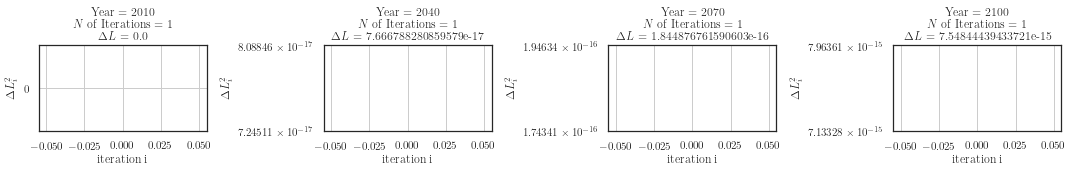

CPU times: user 20.8 s, sys: 982 ms, total: 21.8 s
Wall time: 26.4 s


In [31]:
%%time
m1 = model(name="moderate, bilateral mig",label='Moderate')
m1.technology_calib()
m1.calib_migcosts()
m1.fertility()
m1.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Minor bilateral

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


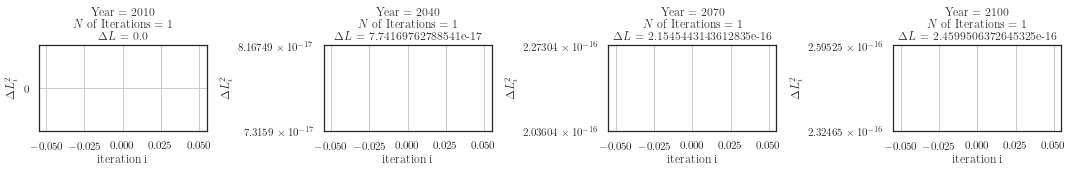

CPU times: user 20.1 s, sys: 839 ms, total: 21 s
Wall time: 24.2 s


In [32]:
%%time
m2 = model(name="minor, bilateral mig", label='Minor', sea_level=0, temperature=0.09,)
m2.technology_calib()
m2.calib_migcosts()
m2.fertility()
m2.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Major bilateral

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


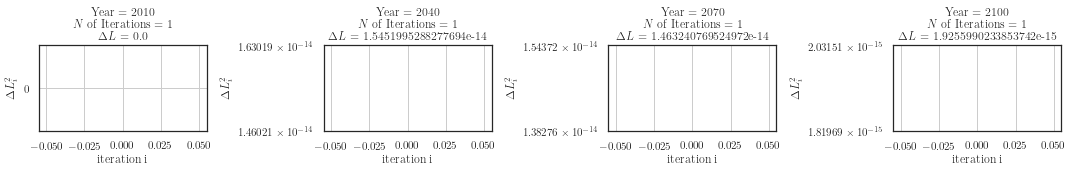

CPU times: user 20.2 s, sys: 838 ms, total: 21 s
Wall time: 24.3 s


In [33]:
%%time
m3 = model(name='major, bilateral mig', label='Major', sea_level=1.3, temperature=4.09)
m3.technology_calib()
m3.calib_migcosts()
m3.fertility()
m3.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Moderate no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


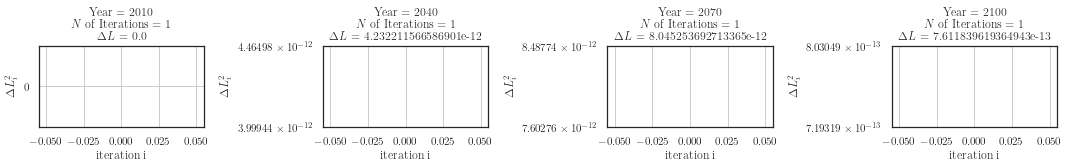

CPU times: user 21 s, sys: 794 ms, total: 21.8 s
Wall time: 24.9 s


In [85]:
%%time
m4 = model(name='moderate no South')
m4.technology_calib()
m4.calib_migcosts()
m4.fertility()
m4.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')

## Minimalist no South

In [659]:
%%time
m5 = model(name='minor no South', sea_level=0, temperature=0.09)
m5.technology_calib()
m5.calib_migcosts()
m5.fertility()
m5.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')

KeyboardInterrupt: 

## Maximalist no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


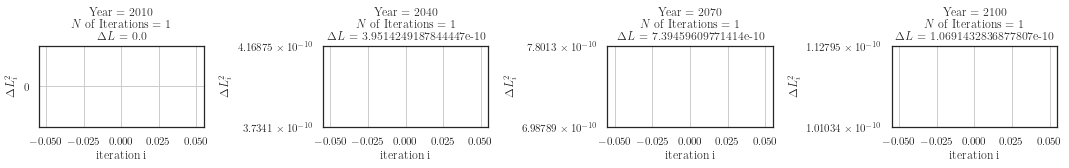

CPU times: user 21 s, sys: 981 ms, total: 22 s
Wall time: 25.1 s


In [87]:
%%time
m6 = model(name='maximalist no South', sea_level=1.3, temperature=4.09)
m6.technology_calib()
m6.calib_migcosts()
m6.fertility()
m6.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')

## Intermediate no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


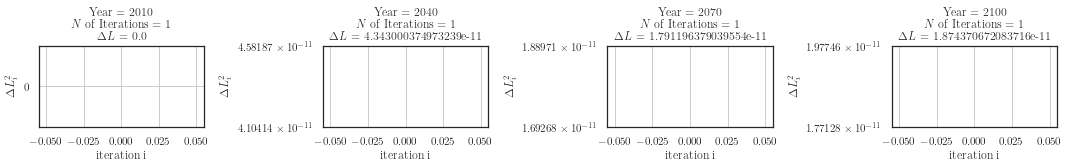

CPU times: user 21.2 s, sys: 939 ms, total: 22.1 s
Wall time: 25.4 s


In [88]:
%%time
m7 = model(name='intermediate no North')
m7.technology_calib()
m7.calib_migcosts()
m7.fertility()
m7.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')

## Minimalist no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


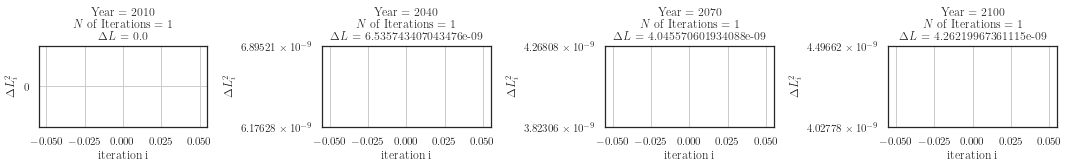

CPU times: user 21.5 s, sys: 921 ms, total: 22.4 s
Wall time: 25.8 s


In [89]:
%%time
m8 = model(name='minimalist no North', sea_level=0, temperature=0.09)
m8.technology_calib()
m8.calib_migcosts()
m8.fertility()
m8.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')

## Maximalist no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


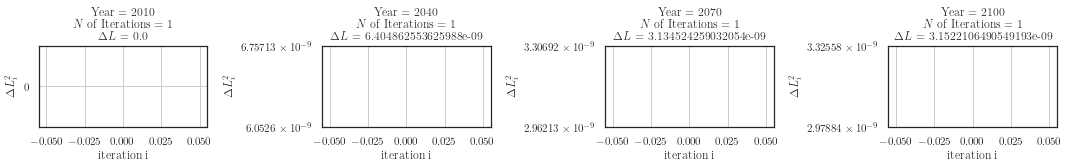

CPU times: user 21.1 s, sys: 943 ms, total: 22.1 s
Wall time: 25.3 s


In [90]:
%%time
m9 = model(name='maximalist no North', sea_level=1.3, temperature=4.09)
m9.technology_calib()
m9.calib_migcosts()
m9.fertility()
m9.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')

## Intermediate compensation for flooding

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


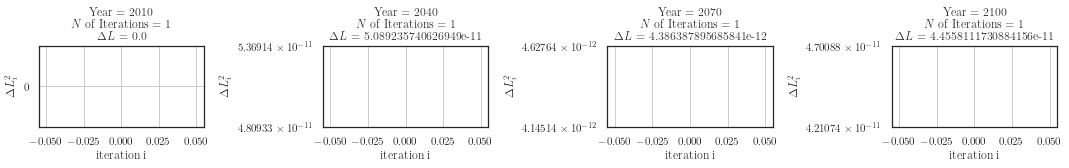

CPU times: user 21.2 s, sys: 928 ms, total: 22.1 s
Wall time: 25.4 s


In [91]:
%%time
m10 = model(name="intermediate compensate flooded", χ={'d': 0.0, 'f': 0.0})
m10.technology_calib()
m10.calib_migcosts()
m10.fertility()
m10.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


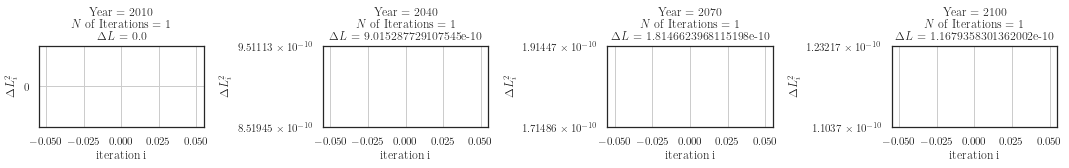

CPU times: user 22 s, sys: 997 ms, total: 23 s
Wall time: 26.6 s


In [92]:
%%time
m10min = model(name="m compensate flooded", χ={'d': 0.0, 'f': 0.0},sea_level=0,temperature=0.09)
m10min.technology_calib()
m10min.calib_migcosts()
m10min.fertility()
m10min.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Intermediate proportional increase

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


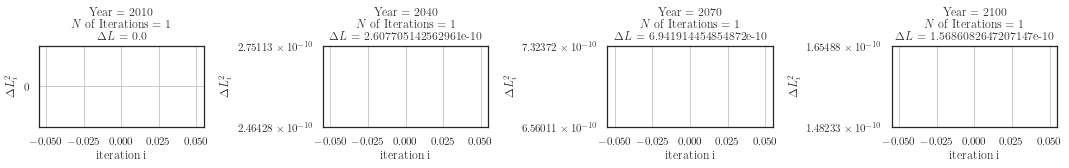

CPU times: user 21.2 s, sys: 836 ms, total: 22 s
Wall time: 25.4 s


In [93]:
%%time
m11 = model(name="intermediate proportional increase")
m11.technology_calib()
m11.calib_migcosts()
m11.fertility()
m11.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='proporional_increase')

## Intermediate proportional decrease

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


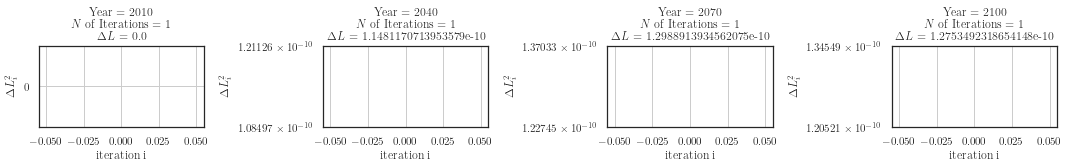

CPU times: user 21.7 s, sys: 870 ms, total: 22.6 s
Wall time: 25.8 s


In [94]:
%%time
m12 = model(name="intermediate proportional decrease")
m12.technology_calib()
m12.calib_migcosts()
m12.fertility()
m12.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='proporional_decrease')

## Intermediate no international

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


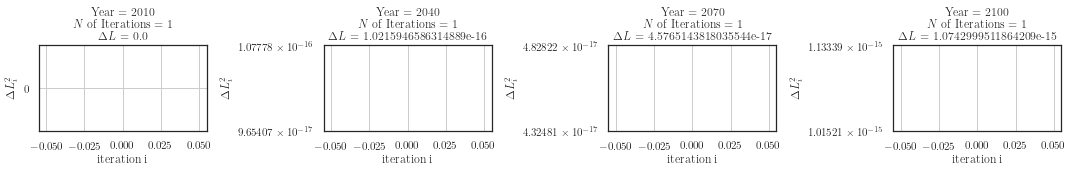

CPU times: user 21 s, sys: 905 ms, total: 21.9 s
Wall time: 25.5 s


In [31]:
%%time
m13 = model(name="moderate no international mig",label='Moderate $x_{ij} = 1$')
m13.technology_calib()
m13.calib_migcosts()
m13.fertility()
m13.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_international')

## Intermediate no internal

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


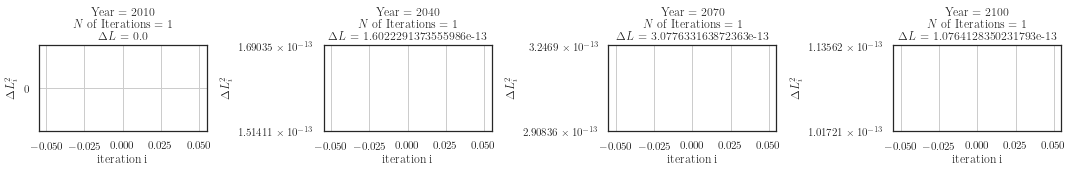

CPU times: user 20.9 s, sys: 853 ms, total: 21.7 s
Wall time: 25.6 s


In [32]:
%%time
m14 = model(name="moderate no internal mig",label='Moderate $x_{ii} = 1$')
m14.technology_calib()
m14.calib_migcosts()
m14.fertility()
m14.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_internal')

## Intermediate no migration

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


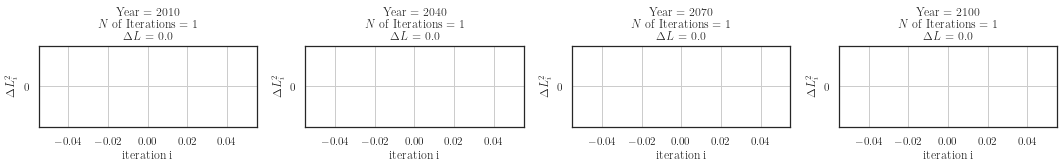

CPU times: user 22.2 s, sys: 820 ms, total: 23 s
Wall time: 21.8 s


In [97]:
%%time
m15 = model(name="intermediate no mig")
m15.technology_calib()
m15.calib_migcosts()
m15.fertility()
m15.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no')

## Intermediate no flooding

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


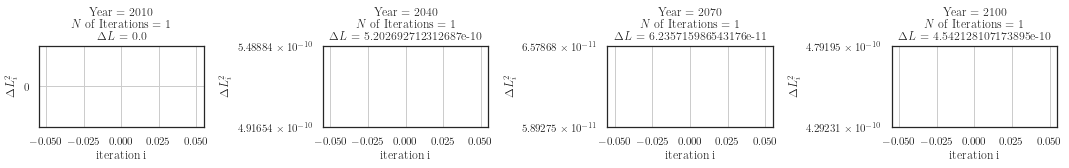

CPU times: user 20.9 s, sys: 405 ms, total: 21.3 s
Wall time: 26 s


In [98]:
%%time
m16 = model(name="intermediate_no_sea_rise", sea_level=0)
m16.technology_calib()
m16.calib_migcosts()
m16.fertility()
m16.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Minimalist no flooding

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


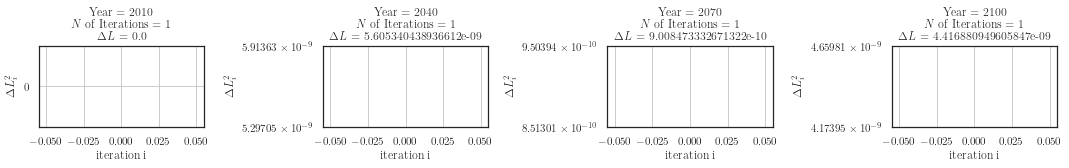

CPU times: user 23.5 s, sys: 897 ms, total: 24.4 s
Wall time: 23.3 s


In [99]:
%%time
m17 = model(name="minimalist_no_sea_rise", sea_level=0, temperature=0.09)
m17.technology_calib()
m17.calib_migcosts()
m17.fertility()
m17.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Maximalist no flooding

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


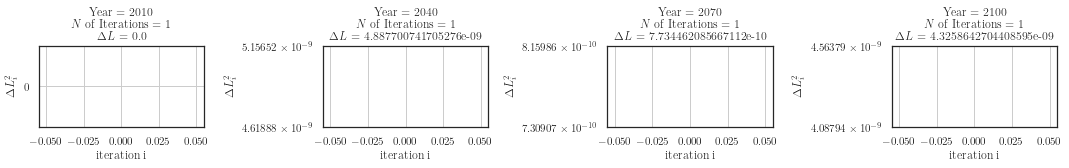

CPU times: user 22.5 s, sys: 392 ms, total: 22.9 s
Wall time: 27.2 s


In [100]:
%%time
m18 = model(name="maximalist_no_sea_rise", sea_level=0, temperature=4.09)
#m18.ω = 0 * m18.ω # No sea-level rise
m18.technology_calib()
m18.calib_migcosts()
m18.fertility()
m18.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Intermediate no TFP effect

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


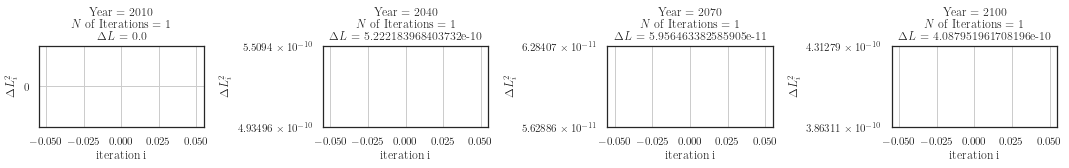

CPU times: user 21.5 s, sys: 1.05 s, total: 22.6 s
Wall time: 26.3 s


In [101]:
%%time
m19 = model(name="intermediate no TFP effect", temperature=0.09)
m19.technology_calib()
m19.calib_migcosts()
m19.fertility()
m19.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Maximalist, pessimistic sea level

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


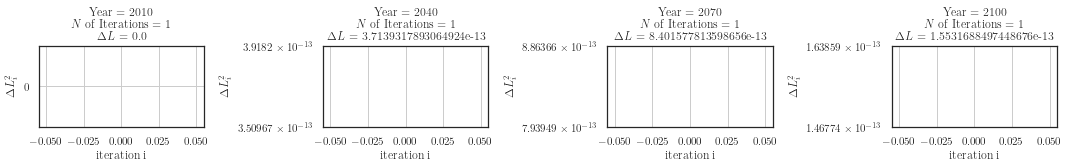

CPU times: user 21.6 s, sys: 938 ms, total: 22.6 s
Wall time: 26 s


In [102]:
%%time
m20 = model(name='maximalist pessimistic sea level, bilateral mig', sea_level=2.7, temperature=4.09)
m20.technology_calib()
m20.calib_migcosts()
m20.fertility()
m20.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

# Outputs

## Stackplots

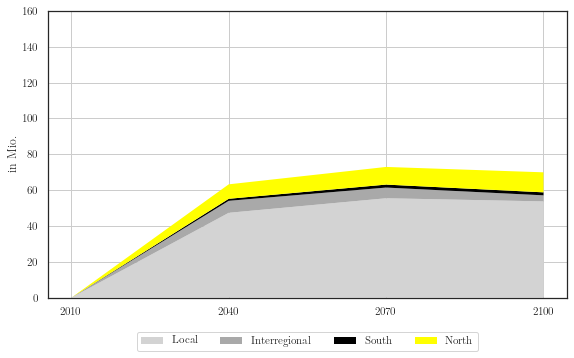

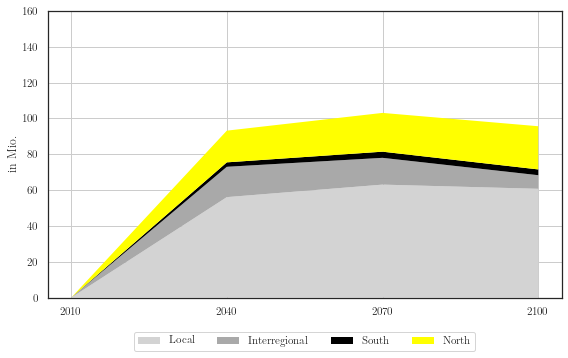

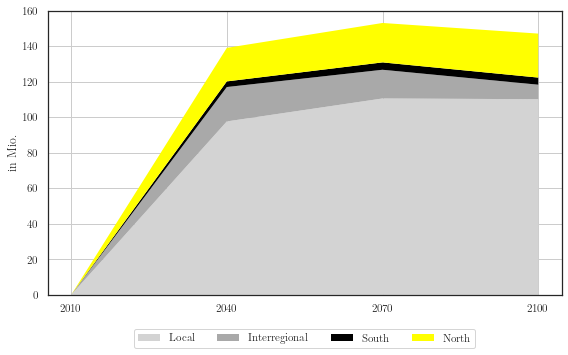

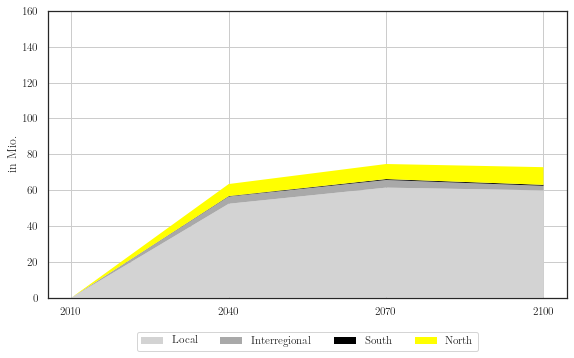

In [39]:
m1.out_stackplot(m2,save=True,name='int_min_full.pdf',ylim=160,title=None)
m3.out_stackplot(m2,save=True,name='max_min_full.pdf',ylim=160,title=None)
m20.out_stackplot(m2,save=True,name='max_pess_min_full.pdf',ylim=160,title=None)
m10.out_stackplot(m10min,save=True,name='int_compenstation_full.pdf',ylim=160,title=None)

In [64]:
m1.out_migrant_world_stock()-m2.out_migrant_world_stock()

t,2010,2040,2070,2100
Local,0.0,47.361517,55.476498,53.721944
Interregional,0.0,6.684824,5.961322,3.379282
North-North,0.0,-0.223804,0.283044,0.370531
North-South,0.0,-0.209566,-0.119789,-0.070149
South-North,0.0,8.292369,9.566715,10.800663
South-South,0.0,1.341580,1.782505,1.744547


In [65]:
m3.out_migrant_world_stock()-m2.out_migrant_world_stock()

t,2010,2040,2070,2100
Local,0.0,56.103045,63.082843,60.748226
Interregional,0.0,16.927177,14.942185,7.587806
North-North,0.0,-0.396694,0.477590,0.615171
North-South,0.0,-0.423921,-0.250422,-0.150482
South-North,0.0,18.087212,21.161117,23.477677
South-South,0.0,2.897888,3.683930,3.377658


## Distribution plots

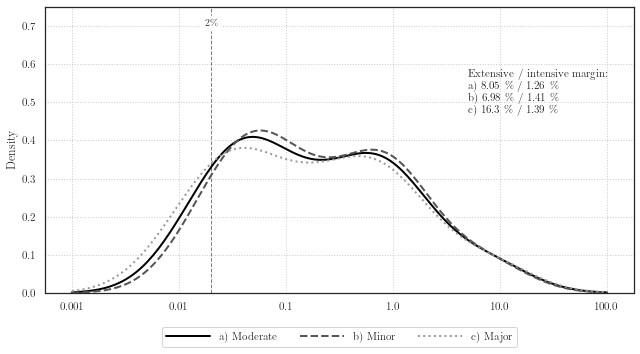

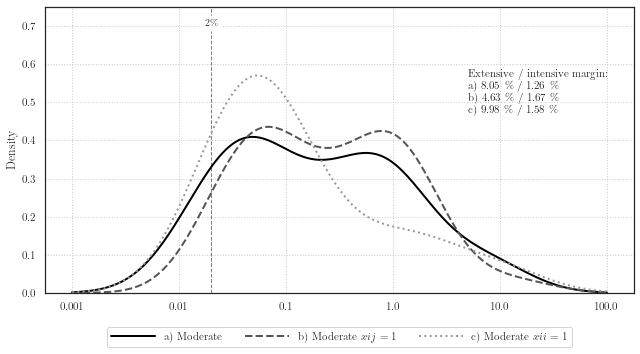

In [38]:
m1.out_distplot([m2,m3],text=True,save=True,cols=3,save_name='Fig7.pdf',show_scenario=False)
m1.out_distplot([m13,m14],text=True,save=True,save_name='closing_borders.pdf',cols=3,show_scenario=False)

# m1.out_distplot([m0],text=True,save=True,save_name='BDSvsBDDM.pdf',cols=1)
# m5.out_distplot([m4,m6],text=True,save=True,save_name='nosouth.pdf',cols=2)
# m8.out_distplot([m7,m9],text=True,save=True,save_name='nonorth.pdf',cols=2)
# m1.out_distplot([m4,m7],text=True,save=True,save_name='full_nosouth_nonorth.pdf',cols=2,show_scenario=False)
# m1.out_distplot([m11,m12],text=True,cols=2,save=True,save_name='proportional_change.pdf',show_scenario=False)
# m1.out_distplot([m10],text=True,cols=1,save=True,save_name='compensating_flooded.pdf',show_scenario=False)
# m1.out_distplot([m16],text=True,cols=1,save=True,save_name='no_flooding.pdf')
# m1.out_distplot([m19],text=True,cols=1,save=True,save_name='no_TFP_effect.pdf')
# m1.out_distplot([m20,m3],text=True,cols=1,save=True,save_name='pessimistic_sea_level.pdf')

## World aggregates table

In [39]:
def agg_ef_table(m,on='bddm'):
    tbl = out_world_aggregates(m,on).unstack(-2)[[2040,2070,2100]].swaplevel(1,0,1).stack().unstack().sort_index(0)
    return(tbl)

a = agg_ef_table(m2)
b = agg_ef_table(m1)-agg_ef_table(m2)
c = agg_ef_table(m3)-agg_ef_table(m2)
keys = ['Minor','$\Delta$ Moderate','$\Delta$ Major']
tab = pd.concat([a,b,c],keys=keys,axis=0).swaplevel(0,1,0)
tab = tab.sort_index(axis=0,level=[0,1],ascending=[True,False])

int_min = (m1.out_world_aggregates()-m2.out_world_aggregates()).drop(2010,1).T.reset_index()
max_min = (m3.out_world_aggregates()-m2.out_world_aggregates()).drop(2010,1).T.reset_index()
minimal = (m2.out_world_aggregates()).drop(2010,1).T.reset_index()
int_min['bddm'] = 'World'
int_min[''] = '$\Delta$ Moderate'
int_min = int_min.set_index(['bddm','t','']).unstack(1)
max_min['bddm'] = 'World'
max_min[''] = '$\Delta$ Major'
max_min = max_min.set_index(['bddm','t','']).unstack(1)
minimal['bddm'] = 'World'
minimal[''] = 'Minor'
minimal = minimal.set_index(['bddm','t','']).unstack(1)

tab = tab.append(pd.concat([minimal,max_min,int_min],0))

tab.sort_index(1) 

GDP in 10e9 \$US                     GDP per Worker  \
t                                   2040      2070      2100           2040   
bddm                                                                          
CARE  Minor                       795.36    895.39    936.33        7282.20   
      $\Delta$ Moderate           -22.46    -46.94    -66.02        -192.55   
      $\Delta$ Major              -51.71    -96.21   -131.92        -444.32   
EAP   Minor                      1545.82   1575.94   1447.96       15933.43   
      $\Delta$ Moderate           -80.90    -91.47    -94.26        -779.68   
      $\Delta$ Major             -159.61   -173.76   -177.48       -1539.04   
LAC   Minor                       961.75   1025.41    987.65       39940.06   
      $\Delta$ Moderate           -75.02    -91.48    -93.45       -2859.51   
      $\Delta$ Major             -167.32   -196.26   -198.59       -6410.80   
MENA  Minor                       790.88    966.67   1025.65       27943.55   
      $\Delta$ Moderate           -25.79    -48.10    -55.53        -949.10   
      $\Delta$ Major              -63.11   -101.50   -115.47       -2338.27   
OECD  Minor                      8856.87   8665.30   8340.07      155186.39   
      $\Delta$ Moderate           496.05    451.67    493.21        6288.49   
      $\Delta$ Major              958.04    941.66   1032.07       11388.98   
SSA   Minor                       417.38    776.33   1262.30        7162.62   
      $\Delta$ Moderate           -34.90    -78.37   -145.03        -579.07   
      $\Delta$ Major              -74.96   -161.61   -296.74       -1245.32   
World Minor                     13368.06  13905.04  13999.95       35746.87   
      $\Delta$ Major              441.33    212.30    111.89        1180.33   
      $\Delta$ Moderate           256.98     95.31     38.93         687.27   

                                              HS Share in \%                \
t                             2070       2100           2040   2070   2100   
bddm                                                                         
CARE  Minor                8227.59    9955.27          17.80  20.81  24.97   
      $\Delta$ Moderate    -397.32    -627.76          -0.08  -0.12  -0.12   
      $\Delta$ Major       -806.96   -1238.36          -0.18  -0.18  -0.14   
EAP   Minor               19185.38   22676.90          15.93  21.14  26.71   
      $\Delta$ Moderate    -945.20   -1125.34          -0.14  -0.30  -0.33   
      $\Delta$ Major      -1776.87   -2070.21          -0.29  -0.42  -0.37   
LAC   Minor               47769.16   57584.11          32.29  37.79  43.48   
      $\Delta$ Moderate   -3705.45   -4522.97          -0.05  -0.08   0.01   
      $\Delta$ Major      -7953.28   -9572.30          -0.10   0.04   0.28   
MENA  Minor               30923.62   35785.70          29.08  31.56  35.24   
      $\Delta$ Moderate   -1488.55   -1782.05          -0.07  -0.55  -0.64   
      $\Delta$ Major      -3258.84   -3932.11          -0.14  -0.76  -0.88   
OECD  Minor              184523.95  217785.81          56.44  61.20  65.38   
      $\Delta$ Moderate    5494.06    6279.65          -0.04  -0.53  -0.63   
      $\Delta$ Major      10795.69   12367.07          -0.13  -0.78  -1.00   
SSA   Minor                7458.86    7447.45           5.04   5.48   5.49   
      $\Delta$ Moderate    -689.14    -738.44          -0.10  -0.11  -0.10   
      $\Delta$ Major      -1406.76   -1479.55          -0.22  -0.19  -0.15   
World Minor               35226.03   34021.23          23.01  23.42  22.46   
      $\Delta$ Major        870.76    1130.24           0.00  -0.02   0.21   
      $\Delta$ Moderate     378.19     433.79           0.00  -0.10  -0.02   

                        Population in 10e6                 Urban Share in \%  \
t                                     2040    2070    2100              2040   
bddm                                                                           
CARE  Minor   

In [40]:
#Tab Output
HTML(tab.to_latex(header=True,index=True,bold_rows=True,multicolumn=True,multirow = True,escape=False,multicolumn_format='c'))

## Tables on Emigration/Immigration Stocks

### Emigration

In [550]:
Mmin = m2.M.xs('International',0,6).reset_index().groupby(['s','t','Country']).sum().unstack(['s','t'])[0]
Nmin = m2.N.unstack().reset_index().groupby(['Country','s','t']).sum().unstack(['s','t'])[0]
Mint = m1.M.xs('International',0,6).reset_index().groupby(['s','t','Country']).sum().unstack(['s','t'])[0]
Nint = m1.N.unstack().reset_index().groupby(['Country','s','t']).sum().unstack(['s','t'])[0]
Mmax = m3.M.xs('International',0,6).reset_index().groupby(['s','t','Country']).sum().unstack(['s','t'])[0]
Nmax = m3.N.unstack().reset_index().groupby(['Country','s','t']).sum().unstack(['s','t'])[0]

ESmin = (Mmin/Nmin).dropna(1)
ESint = (Mint/Nint).dropna(1)
ESmax = (Mmax/Nmax).dropna(1)

tab = pd.concat([ESmin,(ESint-ESmin).xs(2100,1,1,False),(ESmax-ESmin).xs(2100,1,1,False)],
          keys=['Minor','$\Delta$ Moderate','$\Delta$ Major'],axis=1)*100

tab = tab.swaplevel(1,0,1).sort_index(axis=1,level=[0,1],ascending=[False,False])
low = tab['l'].sort_values(('$\Delta$ Moderate',2100),ascending=False).reset_index()
high = tab['h'].sort_values(('$\Delta$ Moderate',2100),ascending=False).reset_index()
final = pd.concat([low,high],axis=1,keys=['Low-skilled','College graduates'])
final = round(final.replace(m1.iso.index,m1.iso),2).head(40)

In [551]:
print(final.to_latex(header=True,index=False,bold_rows=True,multicolumn=True,multirow = True,escape=False,multicolumn_format='c'))

\begin{tabular}{lrrrrrrlrrrrrr}
\toprule
Low-skilled & \multicolumn{7}{c}{College graduates} \\
    Country & \multicolumn{4}{c}{Minor} & $\Delta$ Moderate & $\Delta$ Major &           Country & \multicolumn{4}{c}{Minor} & $\Delta$ Moderate & $\Delta$ Major \\
            &   2010 &   2040 &   2070 &   2100 &              2100 & \multicolumn{2}{c}{2100} &   2010 &   2040 &   2070 &   2100 &              2100 &           2100 \\
\midrule
        GUY &  47.18 &  43.75 &  44.11 &  44.70 &              9.32 &          17.51 &               FSM &  43.88 &  42.75 &  41.84 &  41.72 &              7.36 &          14.55 \\
        FSM &  35.02 &  33.12 &  32.78 &  33.25 &              7.86 &          15.89 &               COM &  59.91 &  51.97 &  50.66 &  50.88 &              5.59 &          11.94 \\
        BLZ &  24.12 &  27.82 &  26.92 &  26.31 &              5.17 &          10.88 &               NLD &  18.87 &  12.67 &  11.98 &  11.82 &              5.49 &           5.98 \\
        JAM &  3

### Immigration

In [552]:
Lmin = m2.L.unstack().reset_index().groupby(['s','t','Country']).sum().unstack(['s','t'])[0]
Lint = m1.L.unstack().reset_index().groupby(['s','t','Country']).sum().unstack(['s','t'])[0]
Lmax = m3.L.unstack().reset_index().groupby(['s','t','Country']).sum().unstack(['s','t'])[0]

In [553]:
Imin = m2.M.xs('International',0,6).reset_index().groupby(['s','t','Destination']).sum().unstack(['s','t'])[0]
Iint = m1.M.xs('International',0,6).reset_index().groupby(['s','t','Destination']).sum().unstack(['s','t'])[0]
Imax = m3.M.xs('International',0,6).reset_index().groupby(['s','t','Destination']).sum().unstack(['s','t'])[0]

In [591]:
ISmin = (Imin/Lmin).dropna(1)
ISint = (Iint/Lint).dropna(1)
ISmax = (Imax/Lmax).dropna(1)

tab = pd.concat([ISmin,(ISint-ISmin).xs(2100,1,1,False),(ISmax-ISmin).xs(2100,1,1,False)],
          keys=['Minor','$\Delta$ Moderate','$\Delta$ Major'],axis=1)*100

tab = tab.swaplevel(1,0,1).sort_index(axis=1,level=[0,1],ascending=[False,False])

EU15Plus = ['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland', 'France','Germany',
            'Greece', 'Ireland', 'Italy', 'Japan', 'Luxembourg', 'Portugal', 'Sweden',
            'Switzerland', 'United Kingdom', 'United States','Netherlands']

DESTINATIONS = list(m1.OECD[m1.OECD == 1].index)

low = tab['l'].loc[DESTINATIONS].sort_values(('$\Delta$ Moderate',2100),ascending=False).reset_index()
high = tab['h'].loc[DESTINATIONS].sort_values(('$\Delta$ Moderate',2100),ascending=False).reset_index()
final = pd.concat([low,high],axis=1,keys=['Low-skilled','College graduates'])
final = round(final.replace(m1.iso.index,m1.iso),2)

In [595]:
#print(final.to_latex(header=True,index=False,bold_rows=True,multicolumn=True,multirow = True,escape=False,multicolumn_format='c'))

In [624]:
L = m1.L_data.unstack().reset_index().groupby(['s','t','Country']).sum().unstack(['s','t'])[0]

In [625]:
I = m1.Mij_data.unstack().reset_index().groupby(['s','t','Destination']).sum()[0].unstack(['s','t'])

In [626]:
(I/L).sort_values(by=('h',2100),ascending=False).loc[clist]

s                       h                        l               
t                    2010 2040 2070 2100      2010 2040 2070 2100
Destination                                                      
Portugal         0.725463  NaN  NaN  NaN  0.105289  NaN  NaN  NaN
Luxembourg       0.786183  NaN  NaN  NaN  0.684906  NaN  NaN  NaN
Palestine        0.453153  NaN  NaN  NaN  0.095247  NaN  NaN  NaN
Canada           0.728717  NaN  NaN  NaN  0.258427  NaN  NaN  NaN
United Kingdom   0.623216  NaN  NaN  NaN  0.159066  NaN  NaN  NaN
...                   ...  ...  ...  ...       ...  ...  ...  ...
Solomon Islands  0.010289  NaN  NaN  NaN  0.009738  NaN  NaN  NaN
India            0.004920  NaN  NaN  NaN  0.010466  NaN  NaN  NaN
China            0.009740  NaN  NaN  NaN  0.000752  NaN  NaN  NaN
Ethiopia         0.002348  NaN  NaN  NaN  0.000997  NaN  NaN  NaN
Iran             0.000956  NaN  NaN  NaN  0.011739  NaN  NaN  NaN

[179 rows x 8 columns]

In [620]:
(I/L).sort_values(by=('h',2100),ascending=False)

s                       h                                       l            \
t                    2010      2040      2070      2100      2010      2040   
Destination                                                                   
Portugal         0.725413  0.813158  0.929393  0.975842  0.105289  0.288482   
Luxembourg       0.785832  0.858459  0.923714  0.962424  0.684906  0.886261   
Palestine        0.453153  0.828553  0.877991  0.936934  0.095247  0.118511   
Canada           0.727948  0.757268  0.867955  0.931253  0.258426  0.566783   
United Kingdom   0.619556  0.709039  0.816440  0.893084  0.159064  0.320613   
...                   ...       ...       ...       ...       ...       ...   
Solomon Islands  0.010064  0.006783  0.004895  0.004308  0.009738  0.005034   
India            0.004920  0.004290  0.003885  0.003634  0.010466  0.011291   
China            0.009740  0.003982  0.003089  0.002556  0.000752  0.000634   
Ethiopia         0.002348  0.002395  0.002403  0.002329  0.000997  0.000853   
Iran             0.000956  0.000760  0.001315  0.001831  0.011739  0.052470   

s                                    
t                    2070      2100  
Destination                          
Portugal         0.610662  0.849687  
Luxembourg       0.945020  0.977551  
Palestine        0.211452  0.413123  
Canada           0.735628  0.857120  
United Kingdom   0.530792  0.730585  
...                   ...       ...  
Solomon Islands  0.005587  0.007492  
India            0.011983  0.013213  
China            0.000751  0.000829  
Ethiopia         0.000799  0.000725  
Iran             0.083551  0.107286  

[179 rows x 8 columns]

[0.0, 48.45256142433308]

In [590]:
# r,s,b,t = 'a','l','d',2010
# for t in T:
#     for r in R:
#         for s in S:
#             fig = plt.figure(figsize=(5,5))
#             plt.scatter(m0.mOECD[(r,s,b,t)],m1.mOECD[(r,s,b,t)])
#             plt.xscale('symlog')
#             plt.yscale('symlog')
#             rng= list(pd.concat([m0.mOECD[(r,s,b,t)],m1.mOECD[(r,s,b,t)]]).describe().loc[['min','max']])
#             plt.xlim(rng)
#             plt.ylim(rng)
#             plt.title(r+s+b+str(t))
#             plt.xlabel(m0.name)
#             plt.ylabel(m1.name)
#             plt.show()

In [583]:
rng

[0.0, 6.83142791149708]

In [186]:
# m1.out_lorenz_curve([m2,m3],savename='MinIntMax.pdf')
# m1.out_lorenz_curve([m11,m12],savename='Varying_x.pdf')
# m4.out_lorenz_curve([m7,m13,m14],savename='Migr_scenarios.pdf')

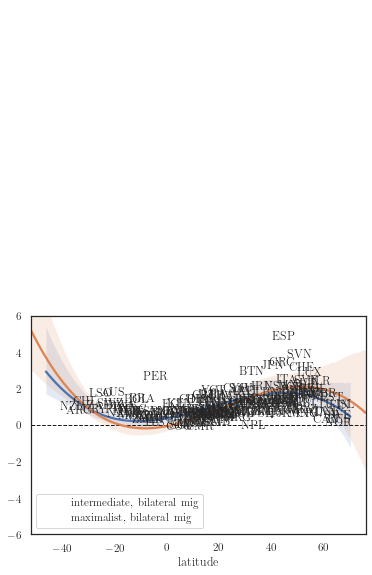

In [87]:
r = 'a'
plt.axhline(0,color='k',linestyle='dashed',linewidth=1)
ax1 = sns.regplot(m1.latitude,(m1.A[(r,2100)]-m1.A[(r,2010)])/m1.A[(r,2010)],order=3,label=m1.name,scatter_kws={'s':0})
ax2 = sns.regplot(m3.latitude,(m3.A[(r,2100)]-m3.A[(r,2010)])/m3.A[(r,2010)],order=3,marker='.',label=m3.name,scatter_kws={'s':0})
for i in list(m1.countries):
    plt.annotate(m1.iso.loc[i],(m1.latitude.loc[i],((m1.A[(r,2100)]-m1.A[(r,2010)])/m1.A[(r,2010)]).loc[i]))
ax1.lines[0].set_linestyle("--")
plt.ylim(-6,6)
plt.legend()
plt.show()

# CLEAN UP FROM HERE

## TFP changes

/home/scheewel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127465 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/scheewel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127466 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/scheewel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 127465 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/scheewel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 127466 missing from current font.
  font.set_text(s, 0, flags=flags)


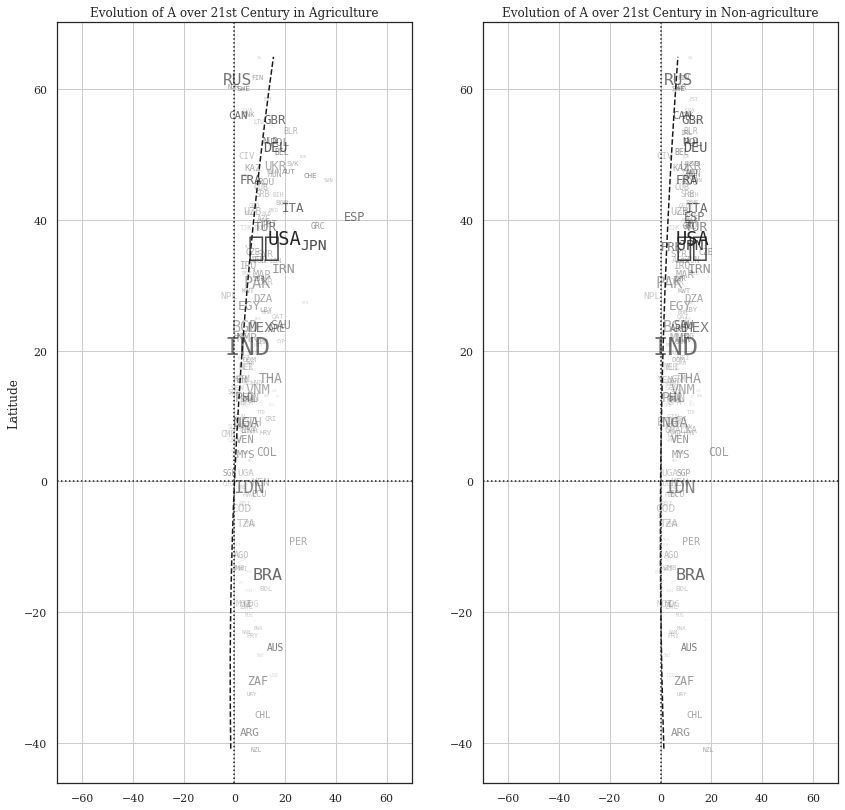

In [34]:
m = m1
var = 'A'
df = (10*(m.__dict__[var].xs(2100,1,1)-m.__dict__[var].xs(2010,1,1))/m.__dict__[var].xs(2010,1,1))
df['latitude'] = m.latitude
hfont = {'fontname':'monospace'}


fig = plt.figure(figsize=(14,14))
sector = {'a': 'Agriculture',
          'n': 'Non-agriculture'}
count = 1
for r in R:
    plt.subplot(1, 2, count)
    x = df[r]
    y = df.latitude
    params = np.polyfit(y,x,2)
    y2 = np.linspace(min(y),max(y),1000)
    x2 = params[0] + params[1] * y2 + params[0] * y2**2
    size = (m.L.xs(2010,1,2).sum(1)/m.L.xs(2010,1,2).sum(1).sum())**(1/4)
    gdppc = (m.w.xs(2010,1,2) * m.L.xs(2010,1,2)).sum(1)
    plt.scatter(x,y,s=0)
    plt.plot(x2,y2,color='k',linestyle='dashed',label=m.name)
    for country in df.index:
        plt.annotate(m.iso.loc[country],(x.loc[country],y.loc[country]),
                 fontsize=40*size.loc[country],alpha=((gdppc/gdppc.max())**(1/5)).loc[country],
                 ha='center',va='center',**hfont)
    plt.axvline(0,color='k',linestyle='dotted')
    plt.axhline(0,color='k',linestyle='dotted')
    plt.xlim([-70,70])
    #plt.xlabel('$(A_{r,2100}-A_{r,2010})/A_{r,2010}$')
    plt.title('Evolution of %s over 21st Century in %s' % (var,sector[r]))
    plt.grid()
    if count == 1:
        plt.ylabel('Latitude')
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=1,handlelength=4)
    count += 1
plt.show()
   


In [ ]:
DeltaD = (m1.A.xs(2010,1,1)-m1.A.xs(2100,1,1))/m1.A.xs(2010,1,1)
DeltaD['latitude'] = m1.latitude
DeltaD_max = (m3.A.xs(2010,1,1)-m3.A.xs(2100,1,1))/m3.A.xs(2010,1,1)
DeltaD_max['latitude'] = m3.latitude

hfont = {'fontname':'monospace'}

fig = plt.figure(figsize=(14,14))
count = 1
for r in R:
    plt.subplot(1, 2, count)
    x = DeltaD[r]
    y = DeltaD.latitude
    params = np.polyfit(y,x,2)
    y2 = np.linspace(min(y),max(y),1000)
    x2 = params[0] + params[1] * y2 + params[0] * y2**2
    count += 1
    size = (m1.L.xs(2010,1,2).sum(1)/m1.L.xs(2010,1,2).sum(1).sum())**(1/3.5)
    gdppc = (m1.w.xs(2010,1,2) * m1.L.xs(2010,1,2)).sum(1)
    plt.scatter(x,y,s=1)
    plt.plot(x2,y2)
    for country in DeltaD.index:
        plt.annotate(m1.iso.loc[country],(DeltaD[r].loc[country],DeltaD.latitude.loc[country]),
                     fontsize=40*size.loc[country],alpha=(1-(gdppc/gdppc.max())).loc[country],
                     ha='center',va='center',**hfont)
    x_max = DeltaD_max[r]
    y_max = DeltaD_max.latitude
    params_max = np.polyfit(y_max,x_max,2)
    y_max_2 = np.linspace(min(y_max),max(y_max),1000)
    x_max_2 = params_max[0] + params_max[1] * y_max_2 + params_max[0] * y_max_2**2
    plt.scatter(x_max,y_max,s=1)
    plt.plot(x_max_2,y_max_2)
    plt.axvline(0,color='k',linestyle='dotted')
    plt.axhline(0,color='k',linestyle='dotted')
    plt.xlim([-7,7])
plt.show()

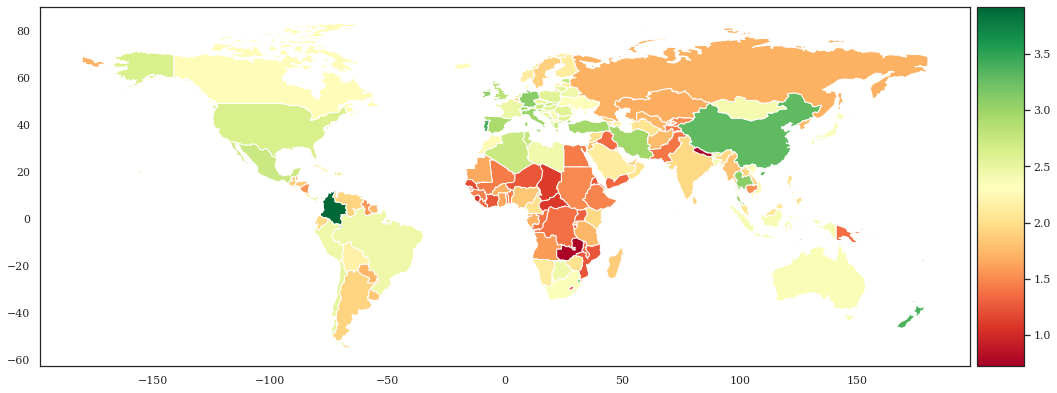

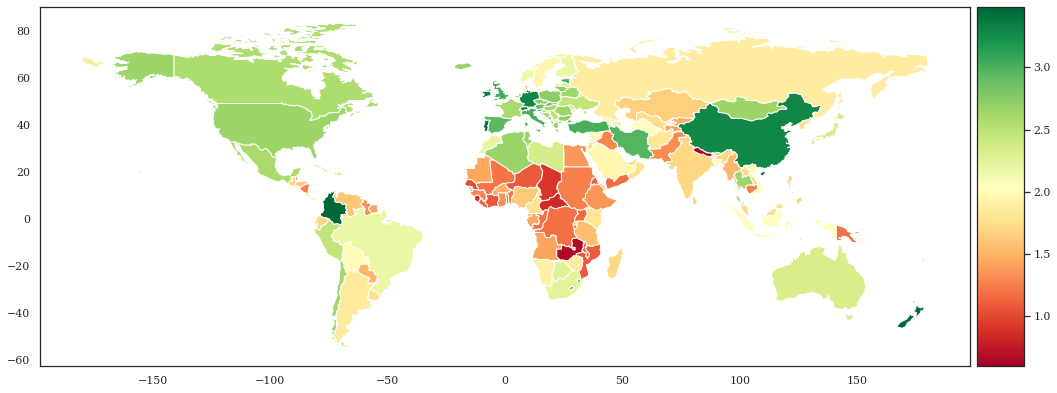

In [539]:
for m in [m1,m3]:
    A = m.A
    Lr = m.L.unstack().reset_index().groupby(['r','t','Country']).sum()[0].unstack([0,1])
    L = m.L.unstack().reset_index().groupby(['t','Country']).sum()[0].unstack().T
    L = pd.concat([L,L],1,keys=['a','n'],names=['r','t'])

    TFP = (A*(Lr/L)).unstack().reset_index().groupby(['t','Country']).sum().unstack(0)[0][[2010,2100]]
    TFP['ratio'] = TFP[2100]/TFP[2010]
    TFP = TFP.join(m.iso)
    TFP = TFP.sort_values('ratio')
    stats = round(TFP.ratio.describe(),4)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    width = 15
    fig, ax = plt.subplots(figsize=(width, 3/8*width))
    ax.set_aspect('equal')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    m.shapes.join(TFP.ratio).plot('ratio', ax=ax, legend=True, cax=cax,cmap='RdYlGn')
    #plt.title('Pop. Weighted TFP ratio: 2100/2010')
    display(HTML('<b>%s $(\mu = %s$, $\sigma =  %s)$</b>' % (m.name,str(stats['mean']),str(stats['mean']))))
    fig.savefig('graphs/maps/TFP2100over2010_%s.pdf' %m.name)
    plt.tight_layout()

    plt.show()

### Theta

`Frédéric:` Hendrik: we have to find how to represent Theta differently (map?)

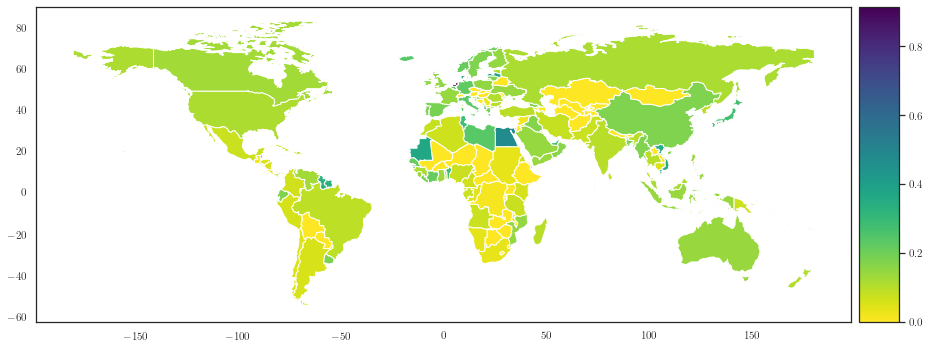

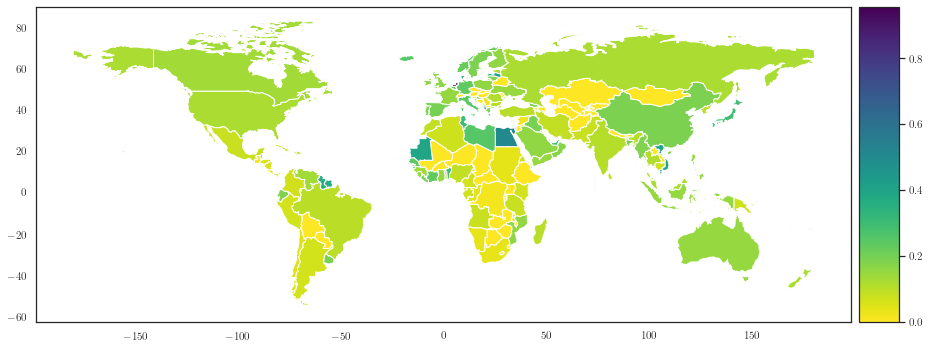

In [170]:
for m in [m1,m3]:
    N = m.N.unstack().reset_index().groupby(['r','t','Country']).sum().unstack([0,1])[0].xs(2100,1,1)
    ω = m.ω.xs(2100,1,1)
    df = pd.DataFrame((N * ω).sum(1)/N.sum(1))
    stats = round(df[0].describe(),4)
    df[0] = (df[0])**(1/2)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, ax = plt.subplots(figsize=(15, 5))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    m.shapes.join(df).plot(0,figsize=(20,10), ax=ax, legend=True, cax=cax,cmap='viridis_r')
    #plt.title('Share of flooded people: 2100')
    display(HTML('<b>%s $(\mu = %s$, $\sigma =  %s)$</b>' % (m.name,str(stats['mean']),str(stats['mean']))))
    plt.tight_layout()
    plt.show()
    fig.savefig('graphs/maps/flooding_%s.pdf' %m.name)


/home/scheewel/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


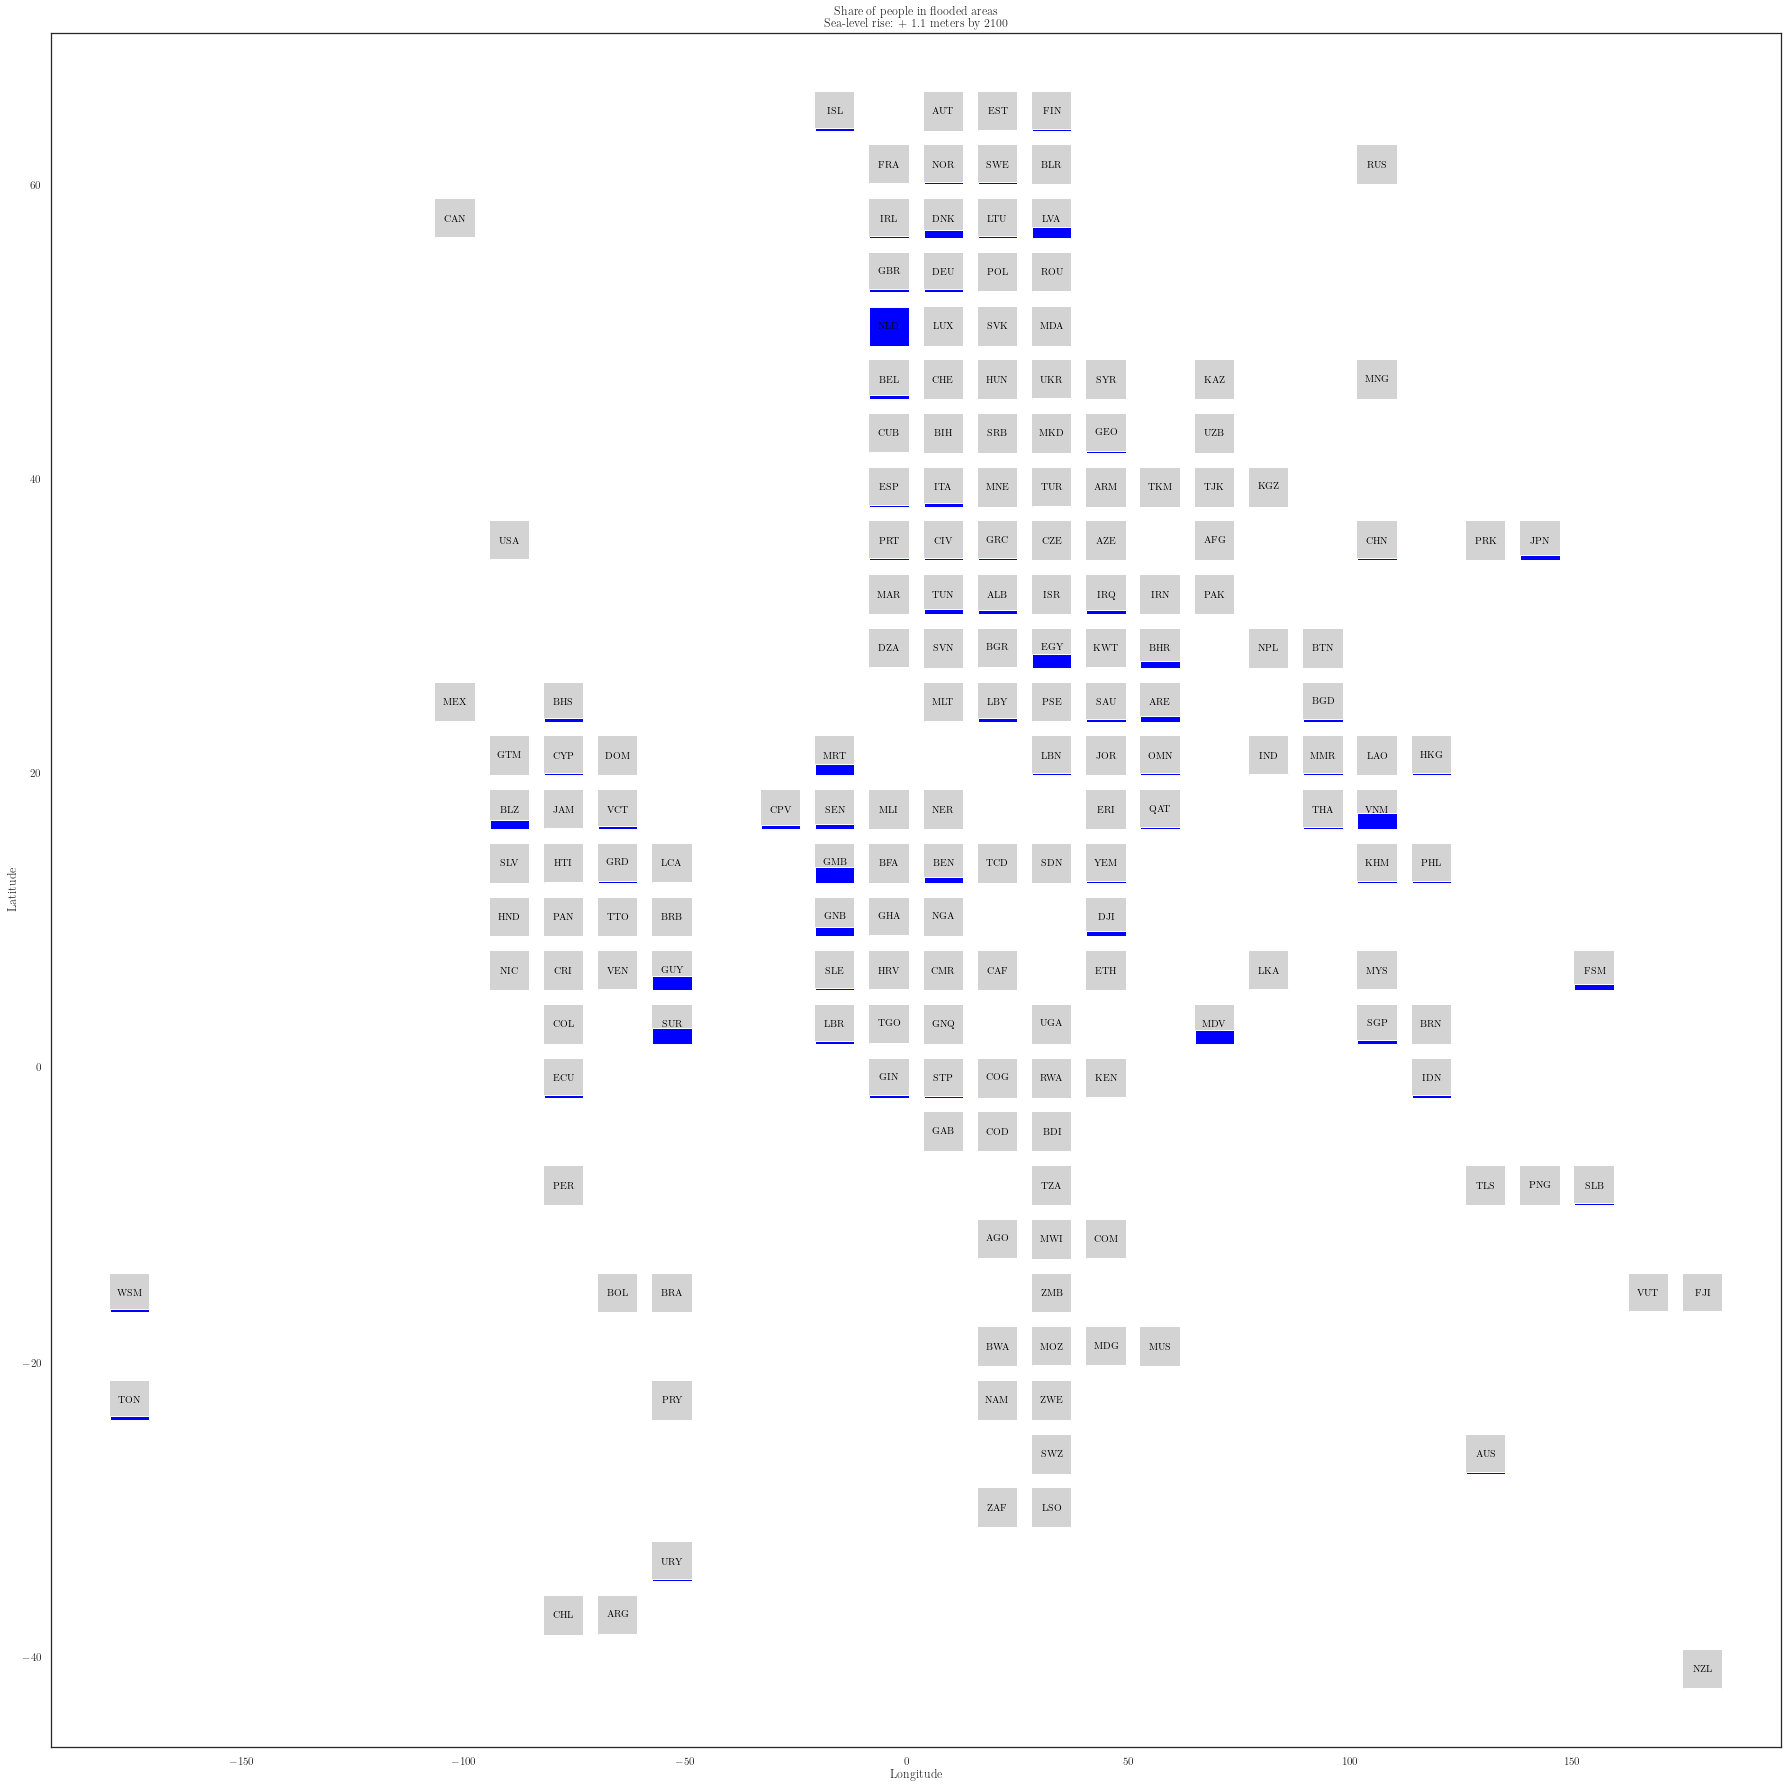

,longitude,latitude,iso3,Unnamed 0,minima,ω
Country,,,,,,
Afghanistan,69.3622,35.7593,AFG,62.4399,6.043033,0.000000
Albania,20.4501,32.1088,ALB,2.89043,3.119426,0.112375
Algeria,-4.00593,28.4584,DZA,213.941,32.278654,0.009405
Angola,20.4501,-11.6968,AGO,104.479,6.881119,0.013679
Argentina,-65.146,-37.2501,ARG,278.33,3.698540,0.016246
...,...,...,...,...,...,...
Venezuela,-65.146,6.55554,VEN,74.5077,2.101614,0.026843
Vietnam,106.046,17.507,VNM,27.2724,5.017751,0.400841
Yemen,44.9062,13.8565,YEM,35.8801,15.910962,0.033520


In [228]:
m20.out_tileplot()

## Result section

### Constant moving costs : Comparison between climate scenarios (i.e. climate migrants)

`Frédéric:` Hendrik: (1) I’d start with your two graphs 4a-4b (I’d put flashy colors for
migration to North (yellow) and to South (red), then interregional in black
and local in grey + one graph per line using full width of the page);

`Frédéric`: (2) Tables 4 is fine but I’d add a column with the sum over the century + a decomposition
by origin (we need to iterate on this table to make sure it is readable =⇒ 2
figures (one page) + 1 table (one page)


#### World stock of climate migrant by type (local, interregional, South-South, South-North) for 2 scenarios

In [165]:
minim = m2.out_migrant_world_stock()
inter = round(m1.out_migrant_world_stock()-minim,4)
maxim = round(m3.out_migrant_world_stock()-minim,4)

tab = pd.concat([inter,maxim],0,keys=['$\Delta$ Intermediate','$\Delta$ Maximalist'])
tab.unstack(0).swaplevel(0,0,1).T.sort_index().T

t                              2010                                      2040  \
              $\Delta$ Intermediate $\Delta$ Maximalist $\Delta$ Intermediate   
Local                           0.0                 0.0               47.3615   
Interregional                   0.0                 0.0                6.6848   
North-North                     0.0                 0.0               -0.2238   
North-South                     0.0                 0.0               -0.2096   
South-North                     0.0                 0.0                8.2924   
South-South                     0.0                 0.0                1.3416   

t                                                  2070                      \
              $\Delta$ Maximalist $\Delta$ Intermediate $\Delta$ Maximalist   
Local                     56.1030               55.4765             63.0828   
Interregional             16.9272                5.9613             14.9422   
North-North               -0.3967                0.2830              0.4776   
North-South               -0.4239               -0.1198             -0.2504   
South-North               18.0872                9.5667             21.1611   
South-South                2.8979                1.7825              3.6839   

t                              2100                      
              $\Delta$ Intermediate $\Delta$ Maximalist  
Local                       53.7219             60.7482  
Interregional                3.3793              7.5878  
North-North                  0.3705              0.6152  
North-South                 -0.0701             -0.1505  
South-North                 10.8007             23.4777  
South-South                  1.7445              3.3777

#### Skill structure of climate migration
`Frédéric:` Hendrik: can you computed the share of college grads in climate migration:
same table as in previous section =⇒ 1 table (one page)

In [627]:
def out_mig_world_stock_by_skill(m,skill='all'):
    M = m.M.reset_index()
    M.Country = M.Country.replace(m.OECD.replace([0,1],['South','North']))
    M.Destination = M.Destination.replace(m.OECD.replace([0,1],['South','North']))
    M['Type'] = np.where(M.Type == 'International', M.Country+'-'+M.Destination,M.Type)
    tab = M.groupby(['Type','s','t']).sum().unstack().drop('Stayers',0)[0]
    if (skill == 'l') | (skill == 'h'):
        return(tab.xs(skill,0,1))
    else:
        ALL_migrants = tab.reset_index().groupby(['Type']).sum()
        return(ALL_migrants)

In [628]:
HS_int = out_mig_world_stock_by_skill(m1,'h')
HS_min = out_mig_world_stock_by_skill(m2,'h')
HS_max = out_mig_world_stock_by_skill(m3,'h')
ALL_int = out_mig_world_stock_by_skill(m1)
ALL_min = out_mig_world_stock_by_skill(m2)
ALL_max = out_mig_world_stock_by_skill(m3)

In [629]:
tab_min = (HS_min/ALL_min).drop([2010],1)
tab_int = (HS_int/ALL_int).drop([2010],1)
tab_max = (HS_max/ALL_max).drop([2010],1)

In [630]:
headers = ['Minor','$\Delta$ Moderate','$\Delta$ Major']

In [653]:
tab = pd.concat([tab_min,tab_int-tab_min,tab_max-tab_min],0,keys=headers)

tab = tab.unstack(0)

tab = round(100*tab.swaplevel(1,0,1).T.sort_index().T,2).sort_index(axis=1,ascending=[False,True])

In [654]:
tab

Minor               $\Delta$ Moderate             $\Delta$ Major  \
t             2040   2070   2100              2040  2070  2100           2040   
Type                                                                            
Internal      8.34   9.02   8.63             -0.13 -0.12 -0.09          -0.30   
Local        14.13  17.23  20.35             13.23  8.81  6.92          13.00   
North-North  54.45  59.22  64.59              0.28 -0.22 -0.22           0.24   
North-South  75.10  78.13  80.96              0.44 -0.06 -0.20           0.66   
South-North  55.22  60.03  63.03             -0.14 -0.43 -0.58          -0.44   
South-South  27.66  28.71  27.83             -0.16 -0.41 -0.41          -0.41   

                         
t            2070  2100  
Type                     
Internal    -0.30 -0.21  
Local        8.48  6.76  
North-North -0.41 -0.34  
North-South -0.09 -0.33  
South-North -0.84 -1.10  
South-South -0.75 -0.75

In [655]:
print(tab[['Minor','$\Delta$ Moderate','$\Delta$ Major']].to_latex(header=True,index=True,bold_rows=True,multicolumn=True,multirow = True,escape=False,multicolumn_format='c'))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} & \multicolumn{3}{c}{Minor} & \multicolumn{3}{c}{$\Delta$ Moderate} & \multicolumn{3}{c}{$\Delta$ Major} \\
\textbf{t} &   2040 &   2070 &   2100 &              2040 &  2070 &  2100 &           2040 &  2070 &  2100 \\
\textbf{Type       } &        &        &        &                   &       &       &                &       &       \\
\midrule
\textbf{Internal   } &   8.34 &   9.02 &   8.63 &             -0.13 & -0.12 & -0.09 &          -0.30 & -0.30 & -0.21 \\
\textbf{Local      } &  14.13 &  17.23 &  20.35 &             13.23 &  8.81 &  6.92 &          13.00 &  8.48 &  6.76 \\
\textbf{North-North} &  54.45 &  59.22 &  64.59 &              0.28 & -0.22 & -0.22 &           0.24 & -0.41 & -0.34 \\
\textbf{North-South} &  75.10 &  78.13 &  80.96 &              0.44 & -0.06 & -0.20 &           0.66 & -0.09 & -0.33 \\
\textbf{South-North} &  55.22 &  60.03 &  63.03 &             -0.14 & -0.43 & -0.58 &          -0.44 & -0.84 & -1.10 \\
\textbf{South

In [137]:
print(tab[['Minimalist','$\Delta$ Intermediate','$\Delta$ Maximalist']].to_latex(header=True,index=True,bold_rows=True,multicolumn=True,multirow = True,escape=False,multicolumn_format='c'))

KeyError: "['Minimalist' '$\\\\Delta$ Intermediate' '$\\\\Delta$ Maximalist'] not in index"

#### Sensibility to sea level
`Frédéric:` In line with Rigaud et al.
(2018), we assume that SLR reaches 2m in 2040. We then prolong the trend and predict
2.4m in 2070 and 2.7m in 2100.
Hendrik: can you simulate this? Michal computed the Theta for this scenario.
We simply need a graph comparable to your current graph 4a. Note that we
could also simulate a scenario without sea level rise. =⇒ 1 or 2 figure(s)

**WHERE CAN I FIND THE DATA?**

#### Inequality and poverty responses
`Frédéric:` Hendrik: can you adjust the comments below; the Appendix can include the
macro projections (your last table)

#### DWorld distribution of income~/DWorld dist. of utility (accounting for 1-x)~ (in the 2 scenarios)

### Role of migration policies
`Frédéric` Hendrik: we should add the various closed-border and openness variants here,
focusing only on the world distribution and poverty implications =⇒ 2 figures
(one page) (one with Moderate + closed-border variants, one with openness variants) comparable to the figures above

#### Changes in mover stocks by region of origin w.r.t. Minimalist (one graph per region, local, intern, to S, to N)

##### Changes in mover stocks by region of destin. w.r.t. Minimalist (one graph per region, local, intern, from S, from N)

#### Table with World Aggregates in 2010, 2040, 2070, 2100 (cols): Population, Share of urban, Share of Colle grads, GDP per capita (rows).

In [67]:
display(m1.out_world_aggregates())
display(m1.out_world_aggregates(on='georegion'))

t,2010,2040,2070,2100
Population in 10e6,313.45,373.96,393.22,407.46
Urban Share in \%,54.14,56.97,56.49,54.47
HS Share in \%,8.97,23.01,23.32,22.44
GDP per Worker,21180.06,36434.14,35604.22,34455.02
GDP in 10e9 \$US,6638.92,13625.04,14000.35,14038.88


t                                 2010       2040       2070       2100
                   georegion                                           
Population in 10e6 Africa        35.26      69.35     115.06     177.01
                   Americas      43.26      49.97      44.05      36.09
                   Asia         194.96     220.63     207.69     173.21
                   Europe        38.37      31.95      24.24      18.88
                   Oceania        1.61       2.06       2.17       2.27
Urban Share in \%  Africa        41.85      40.50      40.22      39.46
                   Americas      79.81      86.12      89.45      91.92
                   Asia          46.63      52.09      55.20      58.27
                   Europe        73.83      79.87      84.17      88.35
                   Oceania       73.77      72.34      64.90      57.08
HS Share in \%     Africa         3.34       7.06       7.03       6.60
                   Americas      17.88      49.29      53.79      59.09
                   Asia           6.14      18.02      22.10      26.94
                   Europe        18.07      49.35      53.77      57.48
                   Oceania       19.78      48.46      45.30      41.11
GDP per Worker     Africa      5436.69    7547.57    7572.08    7343.14
                   Americas   51297.69  112976.85  132527.96  159912.94
                   Asia       10662.76   17128.81   18887.61   21606.45
                   Europe     52560.56  106192.44  126617.07  154912.56
                   Oceania    82590.95  137752.19  137237.90  132701.41
GDP in 10e9 \$US   Africa       191.67     523.42     871.27    1299.81
                   Americas    2218.95    5645.68    5838.51    5771.06
                   Asia        2078.84    3779.12    3922.70    3742.43
                   Europe      2016.84    3393.19    3069.66    2924.41
                   Oceania      132.62     283.63     298.21     301.17

- [ ] Figure with region shares in 2010, 2040, 2070, 2100: in Population, in Urban population, in College-educated population, in total GDP (4 sub-figures)

- [ ] Table with Emigration rates by Region in 2010, 2040, 2070, 2100 (cols): all regions (rows)

In [68]:
m1.out_emigration_rate_by_wbregion()

,2010,2040,2070,2100
wbregion,,,,
EAS,1.56,2.79,3.14,3.31
ECS,8.93,10.46,10.13,9.59
LCN,5.51,6.24,4.86,3.77
MEA,7.41,8.89,9.76,10.37
NAC,1.15,1.37,1.06,0.84
SAS,3.72,4.56,4.87,5.23
SSF,4.09,4.29,4.34,4.39


- [ ] Table with Immigration rates by Region in 2010, 2040, 2070, 2100 (cols): all regions (rows)

In [69]:
m1.out_immigration_rate_by_country()

t,2010,2040,2070,2100
Country,,,,
Germany,23.32,40.09,48.11,55.65
France,23.66,39.73,53.17,67.46
United Kingdom,24.49,51.70,69.89,83.51
Italy,15.03,27.27,35.17,44.65
Spain,20.68,39.61,45.54,50.81
United States,25.13,46.03,52.68,57.64
Canada,38.84,69.92,83.36,91.43
Australia,45.00,66.78,75.97,82.54


- [ ] Figures with decomposition of mover stocks in 2010, 2040, 2070, 2100: one figure per region of origin; shares of local, interregional, international S-S, international S-N

- [ ] Figures with decomposition of mover stocks in 2010, 2040, 2070, 2100: one figure per region of destination; shares of local, interregional, S-S, S-N

- [ ] In the Minimalist scenario: World distribution of income  / World dist. of utility (accounting for 1-x)

## Additional plots & tables

In [70]:
m1.out_world_aggregates('income_group')

t                                    2010       2040       2070       2100
                   income_group                                           
Population in 10e6 HIC              54.50      55.03      46.97      39.89
                   LIC              19.80      33.28      56.18      97.77
                   LMC             111.92     161.52     185.76     189.19
                   UMC             127.23     124.13     104.31      80.61
Urban Share in \%  HIC              80.51      87.69      91.10      93.61
                   LIC              37.70      34.03      32.41      31.55
                   LMC              38.08      39.90      42.82      45.99
                   UMC              59.53      71.72      78.22      82.78
HS Share in \%     HIC              20.66      57.27      60.05      62.92
                   LIC               6.46       6.00       4.55       3.52
                   LMC               6.03      13.33      15.48      17.53
                   UMC               6.95      24.98      30.85      36.90
GDP per Worker     HIC           81565.78  169955.95  195304.17  224520.99
                   LIC            7421.76    6424.84    4165.39    3164.17
                   LMC            4049.63    5950.75    7291.75    9081.49
                   UMC           12521.52   24949.96   31038.99   37901.12
GDP in 10e9 \$US   HIC            4445.64    9353.08    9174.11    8956.37
                   LIC             146.96     213.82     234.01     309.37
                   LMC             453.22     961.19    1354.48    1718.09
                   UMC            1593.10    3096.95    3237.75    3055.05

In [81]:
def world_stock_text_table(mod_int, mod_max, mod_min,latex=False):
    int_min = (mod_int.out_migrant_world_stock()-mod_min.out_migrant_world_stock())
    max_min = (mod_max.out_migrant_world_stock()-mod_min.out_migrant_world_stock())
    int_min['Type'] = int_min.index
    int_min['Type'] = int_min.Type.str.split('-').apply(lambda x: x[-1])
    int_min = int_min.groupby('Type').sum()
    max_min['Type'] = max_min.index
    max_min['Type'] = max_min.Type.str.split('-').apply(lambda x: x[-1])
    max_min = max_min.groupby('Type').sum()
    out = round(pd.concat([int_min,max_min],0,keys=['int-min','max-min']),4)
    if latex == True:
        out = out.to_latex(bold_rows=True,multirow=True)
    return(out)

In [82]:
#table = world_stock_text_table(m1, m3, m2)
table = world_stock_text_table(m7, m9, m8,latex=False)
table

NameError: name 'm7' is not defined

In [ ]:
print(table)

In [ ]:
stackplot(m4,m5,save=True,name='int_min_nosouth.pdf',title='$\Delta$ Intermediate (no South)')
stackplot(m6,m5,save=True,name='max_min_nosouth.pdf',title='$\Delta$ Maximalist (no South)')
stackplot(m7,m8,save=True,name='int_min_nonorth.pdf',title='$\Delta$ Intermediate (no North)')
stackplot(m9,m8,save=True,name='max_min_nonorth.pdf',title='$\Delta$ Maximalist (no North)')

In [109]:
# b = False
# OECD = False

# dic = {
#     'Iij': 'International immigration',
#     'Iii': 'Internal immigration',
#     'Ms': 'Locally displaced people'}

# for var in ['Ms','Iij','Iii']:
#     for t in [2100]:
#         count = 0
#         for by in ['country','georegion','wbregion']:
#             for r in R:
#                 for s in S:
#                     count += 1
#                     fig = plt.figure(figsize=(25,7.5))
#                     a = m1.__dict__[var] - m2.__dict__[var]
#                     b = m3.__dict__[var] - m2.__dict__[var]
#                     c = m4.__dict__[var] - m5.__dict__[var]
#                     d = m6.__dict__[var] - m5.__dict__[var]

#                     if var == 'Ms':
#                         a = a.xs('f',1,2)
#                         b = b.xs('f',1,2)
#                         c = c.xs('f',1,2)
#                         d = d.xs('f',1,2)

#                     if OECD == True:
#                         a = a[m1.OECD == 1]
#                         b = b[m1.OECD == 1]
#                         c = c[m1.OECD == 1]
#                         d = d[m1.OECD == 1]

#                     if by != 'country':
#                         a.index = pd.Series(a.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))
#                         b.index = pd.Series(b.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))
#                         c.index = pd.Series(c.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))
#                         d.index = pd.Series(d.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))

#                         a = a.reset_index().groupby('Country').sum()
#                         b = b.reset_index().groupby('Country').sum()
#                         c = d.reset_index().groupby('Country').sum()
#                         d = d.reset_index().groupby('Country').sum()
#                     else:
#                         a.index = m1.iso
#                         b.index = m1.iso
#                         c.index = m1.iso
#                         d.index = m1.iso
                        
#                         fig = plt.figure(figsize=(25,7.5))
#                         plt.tick_params(axis='x', labelsize=8)

#                     if by == 'subregion':
#                         ms = 12
#                     if by == 'country':
#                         ms = 10

#                     plt.plot(a.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*1.0,label='bilateral migration, intermediate - minimalist')
#                     plt.plot(b.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*0.8,label='bilateral migration, maximalist - minimalist')
#                     plt.plot(c.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*0.6,label='only OECD migration, intermediate - minimalist')
#                     plt.plot(d.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*0.4,label='only OECD migration, maximalist - minimalist')
#                     plt.title("%s by %s, region = %s, skill = %s, year = %s"%(dic[var],by,r,s,t))
#                     rcParams.update({'figure.autolayout': True})
#                     plt.tight_layout()
#                     plt.xticks(rotation='vertical')
#                     plt.legend()
#                     plt.grid(ls=':')
#                     fig.savefig('graphs/movers/%s_%s_%s_%s.pdf' % (by,var,str(t),str(count)))
#                     plt.show()


In [110]:
var = ['A','D','Γ__L']
df = pd.concat([self.__dict__[v] for v in var],axis=1,keys=var)
df.columns.names = ['Variable','r','t']
df = df.unstack().reset_index()
df = df[(df['t'] == 2010) | (df['t'] == 1980)]
df['t'] = df.t.replace([1980,2010],[0,1])
df = df.set_index(['Country','Variable','r','t'])[0].unstack(level=[1,2])
#df = df.reset_index(level=1)

NameError: name 'self' is not defined

In [ ]:
df = df.xs(r,1,1)
df = df.reset_index(level=1)

In [ ]:
reg = sm.ols(formula="np.log(A) - np.log(D) ~ np.log(Γ__L) + t",data=df).fit()

In [ ]:
reg.params['t']

In [ ]:
%%time
m1 = model(name="intermediate, bilateral mig", tol=1e-5, scenario='intermediate')
m1.correct_south_south()
m1.calib_kappa()
m1.calib_A()

self = m1
self.ε = {'a': np.nan, 'n': np.nan}             # aggregate externality
self.A_bar = pd.DataFrame(index=self.countries) # scale factor in TFP

A_D = pd.concat([m1.A.xs(1980,1,1)/m1.D.xs(1980,1,1),m1.A.xs(2010,1,1)/m1.D.xs(2010,1,1)],1,keys=[1980,2010]).swaplevel(1,0,1)

df = pd.concat([self.A,self.Γ__L],1,keys=['A','Γ__L'])

def reg(r):
    df = self.A[r].melt(var_name='year2010',value_name='A')
    df = df.join(self.Γ__L[r].melt(var_name='year2010'
                                   ,value_name='Γ__L')['Γ__L'])
    df['year2010'] = np.where(df.year2010 == 2010,1,0)

    reg = sm.ols(formula="np.log(A) ~ np.log(Γ__L) + year2010", 
                 data=df).fit()

    return(reg.params)

self.γ = reg('a')['year2010'] ** (1/30)
self.γ = 1.00256317290118    

t = 2010
for r in R:
    self.ε[r] = 0.5 * reg(r)['np.log(Γ__L)']
    self.A_bar[r] = self.A[(r,t)]/(self.γ * self.Γ__L[(r,t)]**self.ε[r] * self.D[(r,t)])

In [ ]:
self.ε

In [122]:
m1.out_sankeyplot(aggr_source_by='bddm',aggr_target_by='bddm')

SankeyWidget(layout=Layout(height='800', width='800'), links=[{'source': 'CARE', 'target': 'CARE ', 'value': 7…

t,2010,2040,2070,2100
Country,,,,
Afghanistan,1.115044e+07,1.913839e+07,2.240711e+07,2.025685e+07
Albania,2.303830e+06,1.893649e+06,9.542285e+05,3.830964e+05
Algeria,1.756478e+07,2.699392e+07,2.606068e+07,2.058671e+07
Angola,6.665600e+06,1.835396e+07,3.761331e+07,6.132366e+07
Argentina,1.858806e+07,2.246724e+07,2.193569e+07,1.885665e+07
...,...,...,...,...
Venezuela,1.298693e+07,1.838504e+07,1.776588e+07,1.462070e+07
Vietnam,4.405361e+07,5.352980e+07,5.029933e+07,4.111246e+07
Yemen,8.047168e+06,1.198803e+07,1.599721e+07,1.980833e+07


In [184]:
N = m1.N.unstack().reset_index()

In [187]:
N.Country.replace(m1.bddm.index,m1.bddm)

0       CARE
1       CARE
2       MENA
3        SSA
4        LAC
        ... 
3575     LAC
3576     EAP
3577    MENA
3578     SSA
3579     SSA
Name: Country, Length: 3580, dtype: object

In [236]:
m.__dict__['bddm']

Country
Afghanistan    CARE
Albania        CARE
Algeria        MENA
Angola          SSA
Argentina       LAC
               ... 
Venezuela       LAC
Vietnam         EAP
Yemen          MENA
Zambia          SSA
Zimbabwe        SSA
Name: bddm, Length: 179, dtype: object

In [187]:
def emigrant_shares(self,by='bddm'):
    m = self
    N = m.N.unstack().reset_index()
    N.Country = N.Country.replace(m.__dict__[by].index,m.__dict__[by])
    N = N.groupby(['t','Country']).sum().unstack(0)[0].drop([2130],1)

    M = m.M.xs('International',0,6).reset_index()
    M.Country = M.Country.replace(m.__dict__[by].index,m.__dict__[by])
    M = M.groupby(['t','Country']).sum().unstack(0)[0]
    return(M/N)
    
model.emigrant_shares = emigrant_shares

In [188]:
def immigrant_shares(self,by='bddm'):
    m = self
    L = m.L.unstack().reset_index()
    L.Country = L.Country.replace(m.__dict__[by].index,m.__dict__[by])
    L = L.groupby(['t','Country']).sum().unstack(0)[0]

    I = m.M.xs('International',0,6).reset_index()
    I.Destination = I.Destination.replace(m.__dict__[by].index,m.__dict__[by])
    I = I.groupby(['t','Destination']).sum().unstack(0)[0]
    return(I/L)
    
model.immigrant_shares = immigrant_shares

In [189]:
def net_int_inflow(self,by='bddm'):
    m = self
    I = m.M.xs('International',0,6).reset_index()
    I.Destination = I.Destination.replace(m.__dict__[by].index,m.__dict__[by])
    I = I.groupby(['t','Destination']).sum().unstack(0)[0]
    
    M = m.M.xs('International',0,6).reset_index()
    M.Country = M.Country.replace(m.__dict__[by].index,m.__dict__[by])
    M = M.groupby(['t','Country']).sum().unstack(0)[0]
    return(I-M)
    
model.net_int_inflow = net_int_inflow

In [111]:
interm = pd.concat([m1.emigrant_shares().drop(2010,1),
           m1.immigrant_shares().drop(2010,1),
           m1.net_int_inflow().drop(2010,1)/10e6,],keys=['Emigrant Share',
                           'Immigrant Share',
                           'Net int. inflow in 10e6',],axis=1)

minim = pd.concat([m2.emigrant_shares().drop(2010,1),
           m2.immigrant_shares().drop(2010,1),
           m2.net_int_inflow().drop(2010,1)/10e6,],keys=['Emigrant Share',
                           'Immigrant Share',
                           'Net int. inflow in 10e6',],axis=1)

maxim = pd.concat([m3.emigrant_shares().drop(2010,1),
           m3.immigrant_shares().drop(2010,1),
           m3.net_int_inflow().drop(2010,1)/10e6,],keys=['Emigrant Share',
                           'Immigrant Share',
                           'Net int. inflow in 10e6',],axis=1)

In [112]:
pd.concat([minim,interm-minim,maxim-minim],keys=['Minimalist','$\Delta$ Intermediate','$\Delta$ Maximalist'],axis=0).swaplevel(0,1,0).sort_index(ascending=False)

Emigrant Share                     Immigrant Share  \
t                                    2040      2070      2100            2040   
SSA  Minimalist                  0.058384  0.059523  0.060367        0.030758   
     $\Delta$ Maximalist         0.007908  0.009740  0.010475        0.001419   
     $\Delta$ Intermediate       0.003385  0.004016  0.004309        0.000569   
OECD Minimalist                  0.113318  0.103298  0.093260        0.299579   
     $\Delta$ Maximalist        -0.001820  0.000421  0.001710        0.020621   
     $\Delta$ Intermediate      -0.000961  0.000334  0.001107        0.009537   
MENA Minimalist                  0.120785  0.129963  0.136858        0.162309   
     $\Delta$ Maximalist         0.004464  0.004238  0.004950        0.007767   
     $\Delta$ Intermediate       0.003138  0.003159  0.003741        0.004156   
LAC  Minimalist                  0.104265  0.105809  0.103973        0.016089   
     $\Delta$ Maximalist         0.013865  0.010577  0.007991       -0.000558   
     $\Delta$ Intermediate       0.005888  0.004567  0.003592       -0.000331   
EAP  Minimalist                  0.051624  0.066068  0.077052        0.011399   
     $\Delta$ Maximalist         0.006791  0.008254  0.009191       -0.000213   
     $\Delta$ Intermediate       0.003292  0.003952  0.004531       -0.000101   
CARE Minimalist                  0.077420  0.076458  0.079026        0.034094   
     $\Delta$ Maximalist         0.003937  0.005640  0.007494        0.000014   
     $\Delta$ Intermediate       0.001636  0.002451  0.003366       -0.000069   

                                               Net int. inflow in 10e6  \
t                               2070      2100                    2040   
SSA  Minimalist             0.030359  0.031066               -1.709686   
     $\Delta$ Maximalist    0.002190  0.002516               -0.404690   
     $\Delta$ Intermediate  0.000861  0.000980               -0.175346   
OECD Minimalist             0.366924  0.439581               11.987473   
     $\Delta$ Maximalist    0.027392  0.032971                1.851113   
     $\Delta$ Intermediate  0.012735  0.015760                0.850193   
MENA Minimalist             0.175321  0.192074                1.336697   
     $\Delta$ Maximalist    0.007504  0.007919                0.119841   
     $\Delta$ Intermediate  0.004271  0.004846                0.039570   
LAC  Minimalist             0.015480  0.015078               -2.370400   
     $\Delta$ Maximalist   -0.000514 -0.000595               -0.386169   
     $\Delta$ Intermediate -0.000268 -0.000279               -0.166327   
EAP  Minimalist             0.013508  0.015185               -4.114911   
     $\Delta$ Maximalist   -0.000184 -0.000262               -0.715493   
     $\Delta$ Intermediate -0.000085 -0.000097               -0.346686   
CARE Minimalist             0.030494  0.028182               -5.129172   
     $\Delta$ Maximalist    0.000480  0.000708               -0.464602   
     $\Delta$ Intermediate  0.000229  0.000379               -0.201405   

                                                  
t                                2070       2100  
SSA  Minimalist             -3.227529  -5.285337  
     $\Delta$ Maximalist    -0.779088  -1.202605  
     $\Delta$ Intermediate  -0.330684  -0.524267  
OECD Minimalist             13.805339  14.626014  
     $\Delta$ Maximalist     2.141154   2.362816  
     $\Delta$ Intermediate   0.968650   1.087081  
MENA Minimalist              1.629675   1.833437  
     $\Delta$ Maximalist     0.126629   0.103817  
     $\Delta$ Intermediate   0.043206   0.036251  
LAC  Minimalist             -2.168413  -1.701587  
     $\Delta$ Maximalist    -0.221804  -0.102465  
     $\Delta$ Intermediate  -0.098812  -0.050129  
EAP  Minimalist             -4.622802  -4.280137  
     $\Delta$ Maximalist    -0.684724  -0.532019  
     $\Delta$ Intermediate  -0.330061  -0.267632  
CARE Minimalist             -5.416270  -5.192390  
     $\

In [113]:
m = m1
by = 'bddm'


In [114]:
interm.join(M)

NameError: name 'M' is not defined

In [ ]:
interm

In [115]:
def migrant_numbers(self,by='bddm'):
    m = self
    M = m.M.reset_index()
    M.Country = M.Country.replace(m.__dict__[by].index,m.__dict__[by])
    tab = M[(M.t != 2010) & (M.Type != 'Stayers')].groupby(['t','Type','Country']).sum().unstack([1]).swaplevel(0,1,0).sort_index(0)[0]
    tab = tab.join(pd.DataFrame(tab.sum(1),columns=['Total']))
    
    # Append flooded
    M = m.M.xs('f',0,2).reset_index()
    M.Country = M.Country.replace(m.__dict__[by].index,m.__dict__[by])
    M = M[M.t != 2010].groupby(['Country','t']).sum()
    M = M.rename(columns={0:'of which flooded'})
    tab = tab.join(M)#[['Total','of which flooded','Local','Internal','International']]
    return(tab)

model.migrant_numbers = migrant_numbers

In [116]:
interm = m1.migrant_numbers()
minim = m2.migrant_numbers()
maxim = m3.migrant_numbers()

In [117]:
tab = pd.concat([interm-minim,maxim-minim],keys=['$\Delta$ Intermediate','$\Delta$ Maximalist'],axis=1).swaplevel(1,0,1).T.sort_index(ascending=False).T/1000000

tab = tab[['Total','of which flooded','Local','Internal','International']]

In [121]:
HTML(tab.to_latex(header=True,index=True,bold_rows=True,multicolumn=True,multirow = True,escape=False,multicolumn_format='c'))

In [162]:
ΔIntermediate = (m1.out_migrant_world_stock()-m2.out_migrant_world_stock()).drop(2010,1)
ΔMaximalist = (m3.out_migrant_world_stock()-m2.out_migrant_world_stock()).drop(2010,1)
ΔPessimist = (m20.out_migrant_world_stock()-m2.out_migrant_world_stock()).drop(2010,1)
Minimalist = (m2.out_migrant_world_stock()).drop(2010,1)

In [201]:
print(round(pd.concat([Minimalist,ΔIntermediate,ΔMaximalist,ΔPessimist],keys=['Minimalist','$\Delta$ Intermediate','$\Delta$ Maximalist','$\Delta$ Pessimist'],axis=1).unstack(0).unstack(),2).to_latex(header=True,index=True,bold_rows=True,multicolumn=True,multirow = True,escape=False,multicolumn_format='c'))

\begin{tabular}{llrrrrrr}
\toprule
                   &      &   Local &  Interregional &  North-North &  North-South &  South-North &  South-South \\
{} & \textbf{t} &         &                &              &              &              &              \\
\midrule
\multirow{3}{*}{\textbf{Minimalist}} & \textbf{2040} &    0.00 &         455.97 &        47.87 &         3.24 &       123.11 &       112.80 \\
                   & \textbf{2070} &    0.00 &         433.17 &        32.09 &         2.16 &       140.22 &       131.84 \\
                   & \textbf{2100} &    0.00 &         432.90 &        20.64 &         1.43 &       147.69 &       145.06 \\
\cline{1-8}
\multirow{3}{*}{\textbf{$\Delta$ Intermediate}} & \textbf{2040} &   47.36 &           6.68 &        -0.22 &        -0.21 &         8.29 &         1.34 \\
                   & \textbf{2070} &   55.48 &           5.96 &         0.28 &        -0.12 &         9.57 &         1.78 \\
                   & \textbf{2100} &   53.72 &    

Country
Afghanistan    1.608079e+07
Albania        1.070552e+05
Algeria        1.764545e+07
Angola         5.453924e+07
Argentina      1.759793e+07
                   ...     
Venezuela      1.292070e+07
Vietnam        3.538995e+07
Yemen          1.563879e+07
Zambia         4.392593e+07
Zimbabwe       1.133822e+07
Length: 179, dtype: float64

In [129]:
for m in [m0,m1,m3]:
    m.GDPpC = ((m.Y.xs(2100,1,1).sum(1)/m.L.xs(2100,1,2).sum(1))-(m.Y.xs(2010,1,1).sum(1)/m.L.xs(2010,1,2).sum(1)))/(m.Y.xs(2010,1,1).sum(1)/m.L.xs(2010,1,2).sum(1))
    m.urb = ((m.L.xs(2100,1,2)['n'].sum(1)/m.L.xs(2100,1,2).sum(1))-(m.L.xs(2010,1,2)['n'].sum(1)/m.L.xs(2010,1,2).sum(1)))/(m.L.xs(2010,1,2)['n'].sum(1)/m.L.xs(2010,1,2).sum(1))
    m.urb = ((m.L.xs(2100,1,2)['n'].sum(1)/m.L.xs(2100,1,2).sum(1))-(m.L.xs(2010,1,2)['n'].sum(1)/m.L.xs(2010,1,2).sum(1)))/(m.L.xs(2010,1,2)['n'].sum(1)/m.L.xs(2010,1,2).sum(1))
    m.HSShare = ((m.L.xs(2100,1,2).xs('h',1,1).sum(1)/m.L.xs(2100,1,2).sum(1))-(m.L.xs(2010,1,2).xs('h',1,1).sum(1)/m.L.xs(2010,1,2).sum(1)))/(m.L.xs(2010,1,2).xs('h',1,1).sum(1)/m.L.xs(2010,1,2).sum(1))

In [185]:
A3 = pd.concat([m3.urb,m3.latitude],keys=['urb','lat',],axis=1).reset_index()
A1 = pd.concat([m1.urb,m1.latitude],keys=['urb','lat',],axis=1).reset_index()

A1['model'] = 'Intermediate'
A3['model'] = 'Maximalist'
data = A1.append(A3)

In [186]:
data

,Country,urb,lat,model
0,Afghanistan,-0.083624,33.939110,Intermediate
1,Albania,0.410543,41.153332,Intermediate
2,Algeria,0.180753,28.033886,Intermediate
3,Angola,0.102779,-11.202692,Intermediate
4,Argentina,0.086752,-38.416097,Intermediate
...,...,...,...,...
174,Venezuela,0.100582,6.423750,Maximalist
175,Vietnam,0.323283,14.058324,Maximalist
176,Yemen,0.063595,15.552727,Maximalist
177,Zambia,-0.564665,-13.133897,Maximalist


In [219]:
m1.GDPpC.rank()

Country
Afghanistan     66.0
Albania        114.0
Algeria        164.0
Angola          35.0
Argentina       60.0
               ...  
Venezuela       58.0
Vietnam         86.0
Yemen           14.0
Zambia           2.0
Zimbabwe        59.0
Length: 179, dtype: float64

In [238]:
wA2100 = (m1.L.unstack().reset_index().groupby(['r','t','Country']).sum().unstack([0,1])[0].xs(2100,1,1)*m1.A.xs(2100,1,1)).sum(1)
wA2010 = (m1.L.unstack().reset_index().groupby(['r','t','Country']).sum().unstack([0,1])[0].xs(2010,1,1)*m1.A.xs(2010,1,1)).sum(1)

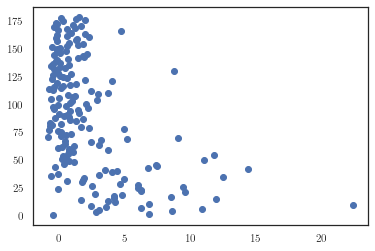

In [250]:
plt.scatter((wA2100-wA2010)/wA2010,m1.GDPpC.rank())
plt.show()

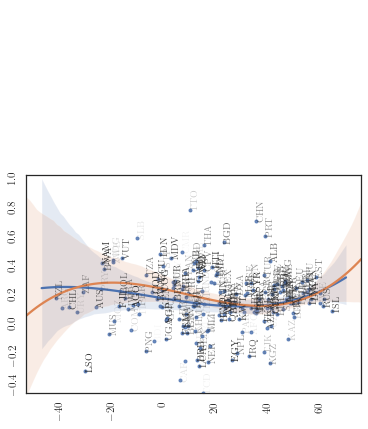

In [217]:
var = 'urb'
sns.regplot(m1.latitude,m1.__dict__[var],order=3,marker='.')
for i in list(m1.latitude.index):
    plt.annotate(m1.iso.loc[i],(m1.latitude.loc[i],m1.__dict__[var].loc[i]),rotation='vertical',alpha=1/m1.GDPpC.loc[i])
sns.regplot(m1.latitude,m3.__dict__[var],order=3,marker='')
plt.xticks(rotation='vertical')
plt.yticks(rotation='vertical')
plt.xlabel('')
plt.ylim([-0.5,1])
plt.show()

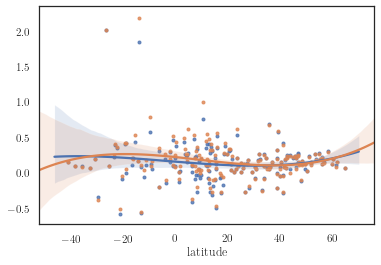

In [131]:
sns.regplot(m1.latitude,m1.urb,order=3,marker='.')
sns.regplot(m1.latitude,m3.urb,order=3,marker='.')
plt.show()

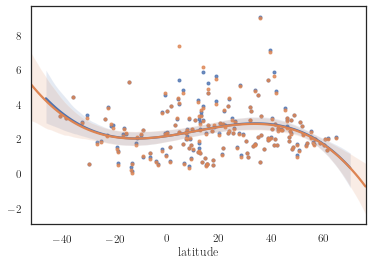

In [141]:
sns.regplot(m1.latitude,m1.HSShare,order=3,marker='.')
sns.regplot(m1.latitude,m3.HSShare,order=3,marker='.')
plt.show()